In [1]:
import pandas as pd
import numpy as np
from workalendar.asia import China
import chinese_calendar as calendar
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from gplearn.genetic import SymbolicTransformer
from xgboost import XGBRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df_raw = pd.read_csv('./ncd5.csv',header=None)
df = df_raw.iloc[4:, :].copy()
df.columns = [
    "date",
    "reverse_repo_7d",
    "reverse_repo_7d_amount",
    "MLF_1y",
    "DXY",
    "DR001",
    "DR007",
    "FR007",
    "CPI_yoy",
    "CPI_mom",
    'CPI',
    "PPI_yoy",
    "PPI_mom",
    "house_listing_index",
    "PMI",
    "tsf",
    "trust_loan",
    "m1_yoy",
    "m2_yoy",
    "tsf_yoy",
    "Shibor",
    "central_bank_bill",
    "ncd_amount",
    "interbank",
    'IBO001',
    'IBO007',
    'SHCOMP',
    'R001',
    'R007',
    "ncd",
    'ncd3m',
    'ncd1y'
]

# 在同业存单之后出现的数据（为了确保我们有尽可能多的数据，在这里删除，同时这几个指标和其他一些指标关联性大，所以删减之后不会有太大问题）
cols_to_drop = [col for col in df.columns if any(key in col for key in ['DR007', 'MLF_1y', 'DR001'])]
# cols_to_drop = [col for col in df.columns if any(key in col for key in ['MLF_1y'])]
df = df.drop(columns=cols_to_drop)

# 清洗数字列：去掉逗号、百分号、中文单位等非数字字符
for col in df.columns:
    if col != "date":
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(",", "", regex=False)   # 去除千位逗号
            .str.replace("%", "", regex=False)   # 去除百分号
            .str.replace("亿", "", regex=False)  # 去除“亿”字
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 按日期升序排序
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)

# 转换为datetime
df["date"] = pd.to_datetime(df["date"])
# df = df[df["date"] >= pd.to_datetime("2019-01-01")].reset_index(drop=True)

In [3]:
df.head()

,date,reverse_repo_7d,reverse_repo_7d_amount,DXY,FR007,CPI_yoy,CPI_mom,CPI,PPI_yoy,PPI_mom,...,ncd_amount,interbank,IBO001,IBO007,SHCOMP,R001,R007,ncd,ncd3m,ncd1y
0,2010-06-01,0.0,0.0,86.89,3.20,NaN,NaN,NaN,NaN,NaN,...,NaN,77.7,2.75,3.20,2568.28,2.74,3.19,NaN,NaN,NaN
1,2010-06-02,NaN,0.0,86.74,3.28,NaN,NaN,NaN,NaN,NaN,...,NaN,77.7,2.76,3.27,2571.42,2.76,3.28,NaN,NaN,NaN
2,2010-06-03,NaN,0.0,87.21,2.95,NaN,NaN,NaN,NaN,NaN,...,NaN,77.7,2.75,3.21,2552.66,2.74,3.15,NaN,NaN,NaN
3,2010-06-04,NaN,0.0,88.30,2.22,NaN,NaN,NaN,NaN,NaN,...,NaN,77.7,2.10,2.22,2553.59,2.10,2.21,NaN,NaN,NaN
4,2010-06-05,NaN,0.0,88.30,2.22,NaN,NaN,NaN,NaN,NaN,...,NaN,77.7,2.10,2.22,2553.59,2.10,2.21,NaN,NaN,NaN


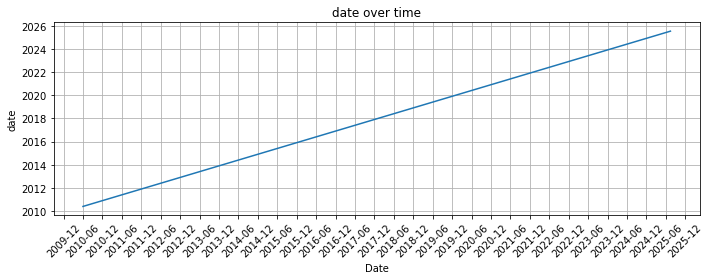

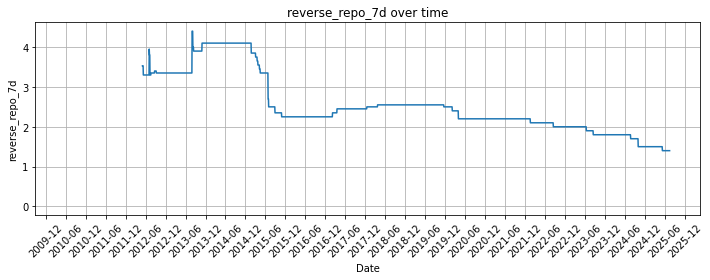

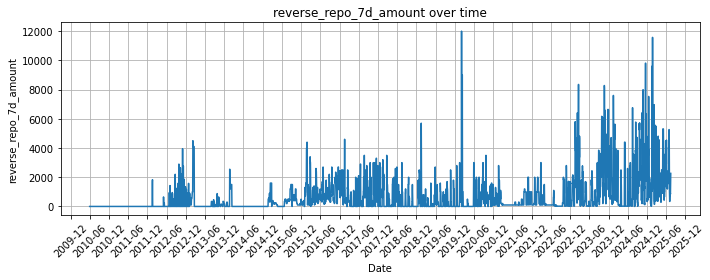

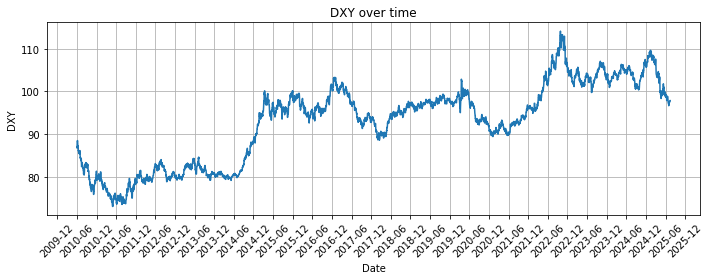

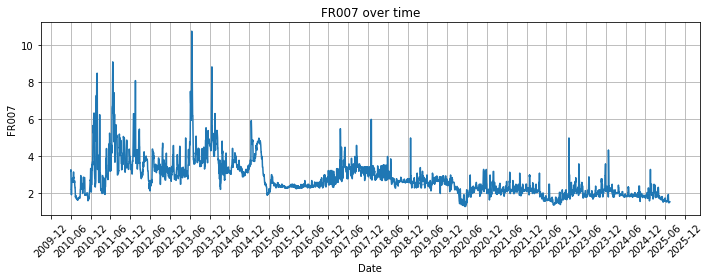

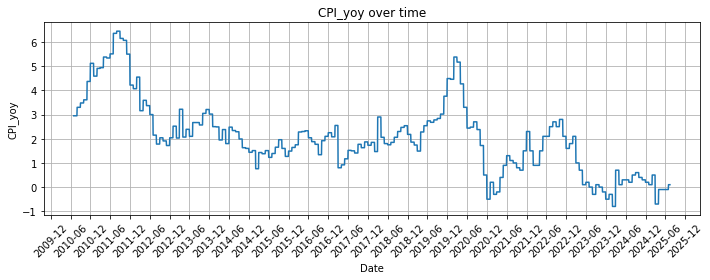

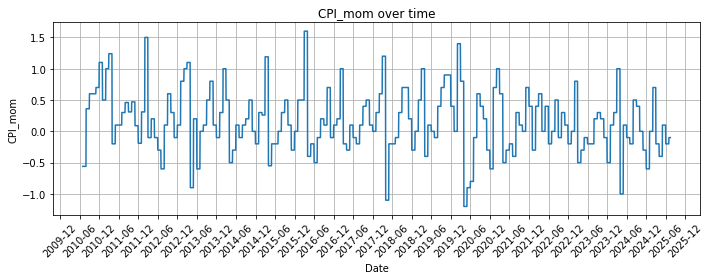

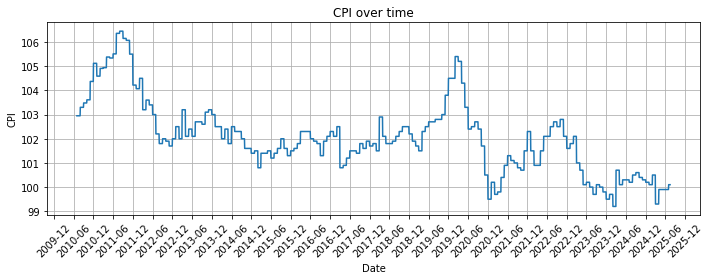

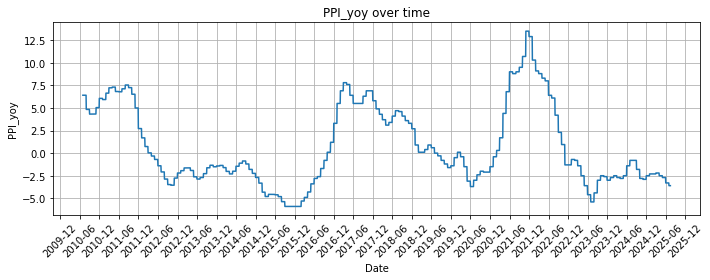

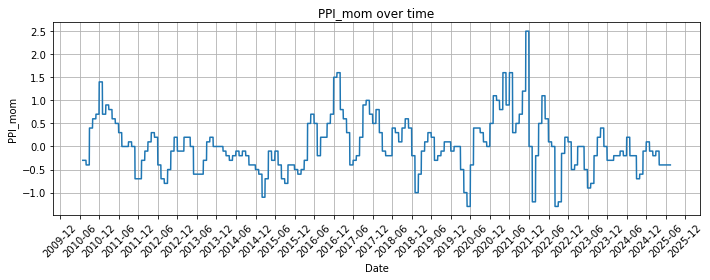

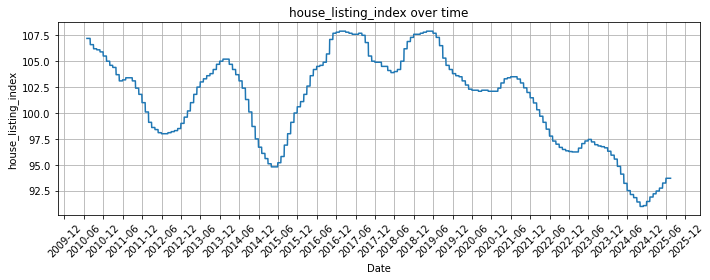

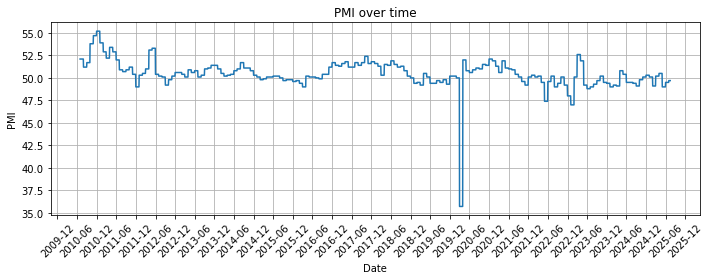

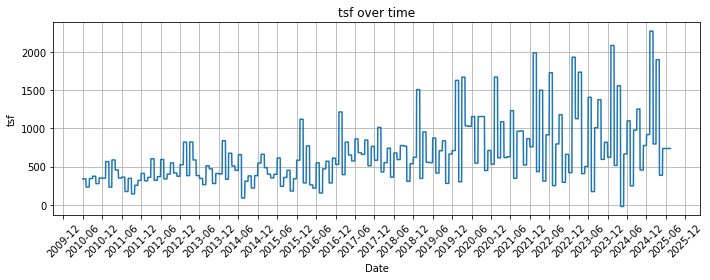

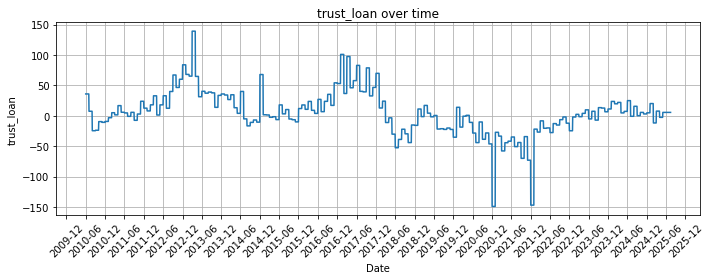

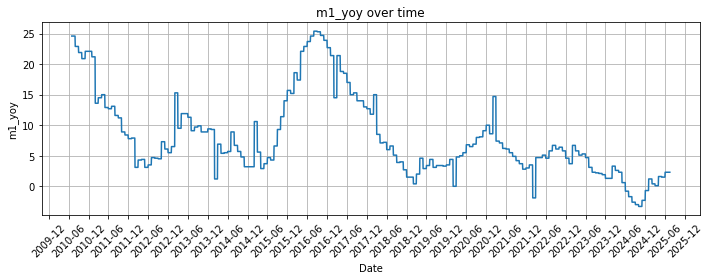

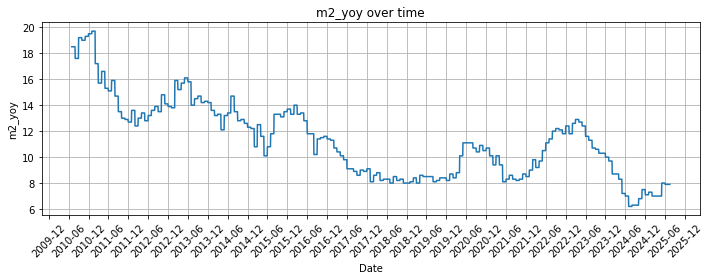

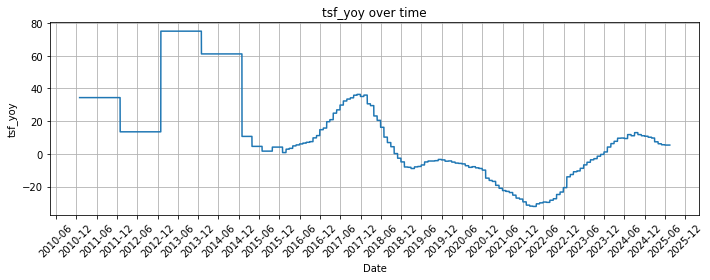

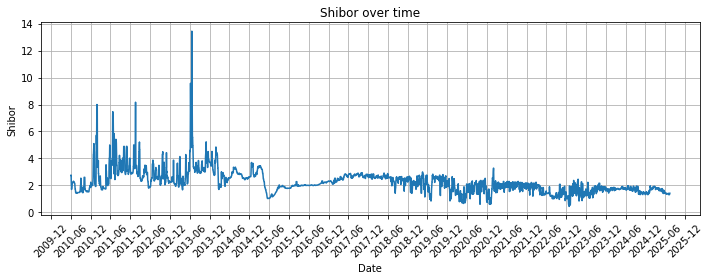

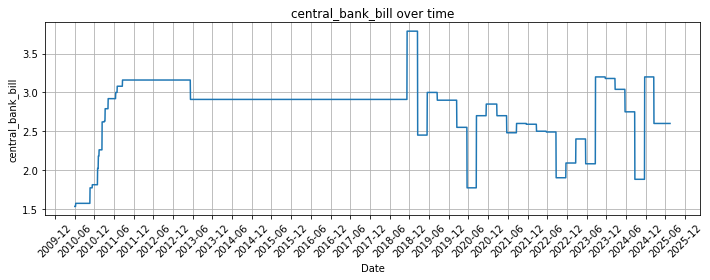

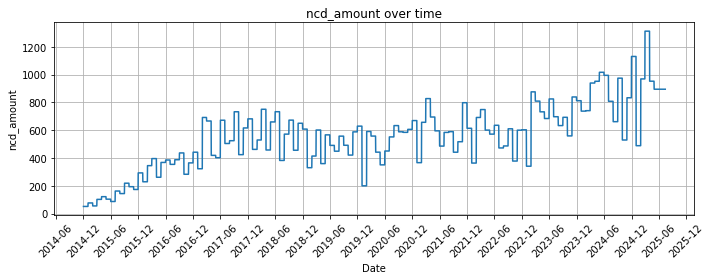

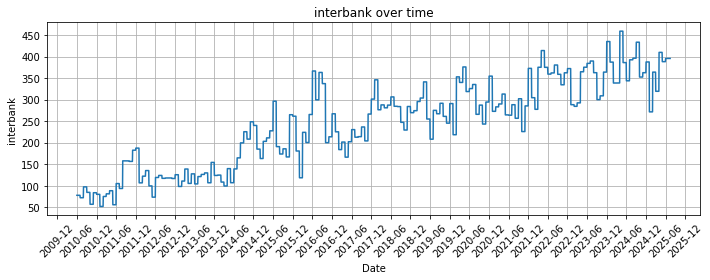

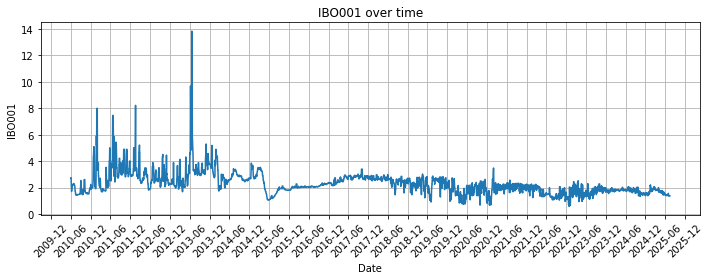

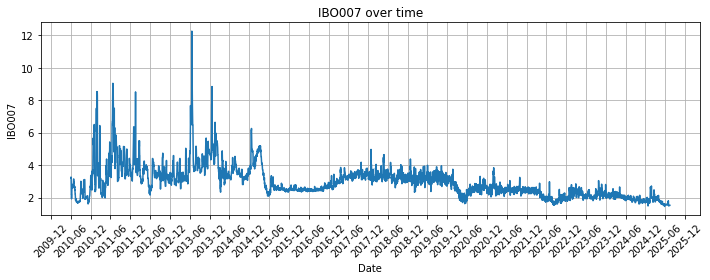

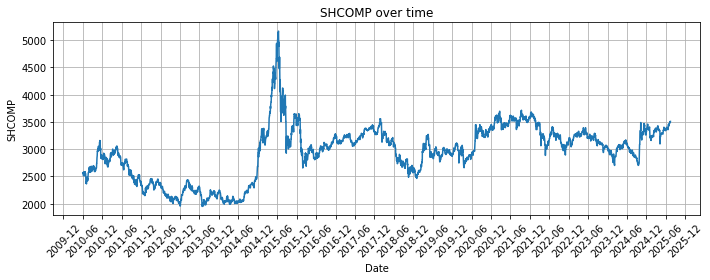

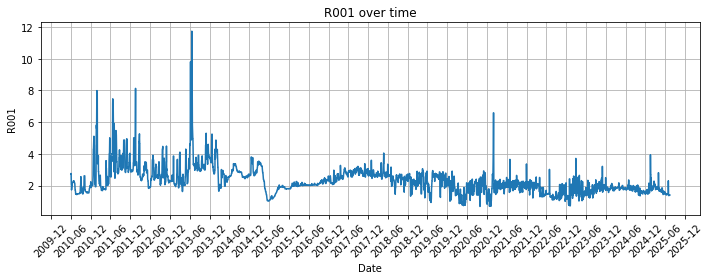

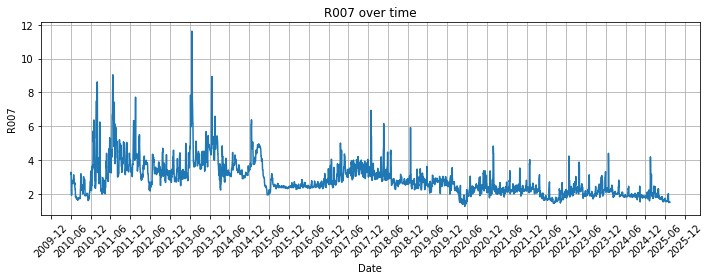

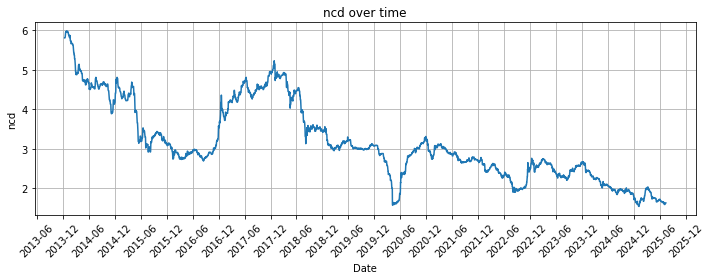

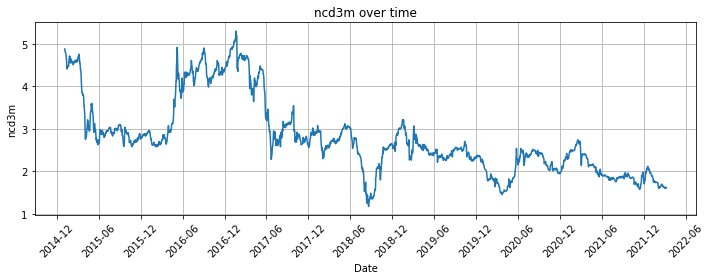

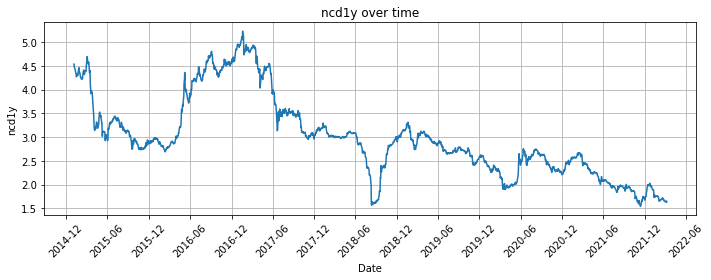

In [4]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# 设置每年6月和12月显示一次
locator = mdates.MonthLocator(bymonth=[6, 12])
formatter = mdates.DateFormatter('%Y-%m')

for col in df.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(df['date'], df[col])
    plt.title(f"{col} over time")
    plt.xlabel("Date")
    plt.ylabel(col)

    ax = plt.gca()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [5]:
# 加权平均
# 找出 CPI 值变化的“锚点日期”
cpi_series = df[["date", "CPI"]].copy()
cpi_series["prev_CPI"] = cpi_series["CPI"].shift(1)
cpi_series["changed"] = cpi_series["CPI"] != cpi_series["prev_CPI"]
release_dates = cpi_series[cpi_series["changed"]]["date"].reset_index(drop=True)

# 确保按时间排序
release_dates = release_dates.sort_values().reset_index(drop=True)

# 初始化新的 CPI 列
cpi_weighted = pd.Series(index=df.index, dtype=float)

# 遍历两个 CPI 发布日之间的区间，做线性插值
for i in range(len(release_dates) - 1):
    start_date = release_dates[i]
    end_date = release_dates[i + 1]

    mask = (df["date"] >= start_date) & (df["date"] <= end_date)
    days_total = (end_date - start_date).days

    val_start = df.loc[df["date"] == start_date, "CPI"].values[0]
    val_end = df.loc[df["date"] == end_date, "CPI"].values[0]

    weights = (df.loc[mask, "date"] - start_date).dt.days / days_total
    interpolated = (1 - weights) * val_start + weights * val_end

    cpi_weighted.loc[mask] = interpolated

# 边界处理（最前面保持原始值或用第一个锚点值填充）
first_value = df.loc[df["date"] == release_dates[0], "CPI"].values[0]
cpi_weighted[df["date"] < release_dates[0]] = first_value

# 最后一个区间后面（可选择是否外推）
last_value = df.loc[df["date"] == release_dates.iloc[-1], "CPI"].values[0]
cpi_weighted[df["date"] > release_dates.iloc[-1]] = last_value

# 将日期和加权 CPI 合并成一个表格查看
cpi_result = pd.DataFrame({
    "date": df["date"],
    "cpi_weighted": cpi_weighted
})

# 显示前几行
print(cpi_result.head(20))

# 或查看收尾数据
print(cpi_result.tail(105))

# 加入新列 CPI
df["CPI_weighted"] = cpi_weighted

         date  cpi_weighted
0  2010-06-01           NaN
1  2010-06-02           NaN
2  2010-06-03           NaN
3  2010-06-04           NaN
4  2010-06-05           NaN
5  2010-06-06           NaN
6  2010-06-07           NaN
7  2010-06-08           NaN
8  2010-06-09           NaN
9  2010-06-10           NaN
10 2010-06-11           NaN
11 2010-06-12           NaN
12 2010-06-13           NaN
13 2010-06-14           NaN
14 2010-06-15           NaN
15 2010-06-16           NaN
16 2010-06-17           NaN
17 2010-06-18           NaN
18 2010-06-19           NaN
19 2010-06-20           NaN
           date  cpi_weighted
5414 2025-03-28     99.841935
5415 2025-03-29     99.861290
5416 2025-03-30     99.880645
5417 2025-03-31     99.900000
5418 2025-04-01     99.902198
...         ...           ...
5514 2025-07-08    100.100000
5515 2025-07-09    100.100000
5516 2025-07-10    100.100000
5517 2025-07-11    100.100000
5518 2025-07-14    100.100000

[105 rows x 2 columns]


In [6]:
def smooth_indicator(df, col_name):
    """
    对某列进行锚点识别 + 线性插值平滑，返回新的 Series。
    """
    series = df[["date", col_name]].copy()
    series["prev_val"] = series[col_name].shift(1)
    series["changed"] = series[col_name] != series["prev_val"]
    release_dates = series[series["changed"]]["date"].reset_index(drop=True).sort_values()

    # 初始化结果
    smoothed = pd.Series(index=df.index, dtype=float)

    for i in range(len(release_dates) - 1):
        start_date = release_dates.iloc[i]
        end_date = release_dates.iloc[i + 1]
        mask = (df["date"] >= start_date) & (df["date"] <= end_date)
        days_total = (end_date - start_date).days

        val_start = df.loc[df["date"] == start_date, col_name].values[0]
        val_end = df.loc[df["date"] == end_date, col_name].values[0]
        weights = (df.loc[mask, "date"] - start_date).dt.days / days_total
        interpolated = (1 - weights) * val_start + weights * val_end

        smoothed.loc[mask] = interpolated

    # 边界填充
    first_value = df.loc[df["date"] == release_dates.iloc[0], col_name].values[0]
    smoothed[df["date"] < release_dates.iloc[0]] = first_value

    last_value = df.loc[df["date"] == release_dates.iloc[-1], col_name].values[0]
    smoothed[df["date"] > release_dates.iloc[-1]] = last_value

    return smoothed

In [7]:
cols_to_smooth = ["CPI_yoy", "CPI_mom", "PPI_yoy", "PPI_mom", "PMI", 
                  "house_listing_index"]

for col in cols_to_smooth:
    df[f"{col}"] = smooth_indicator(df, col)

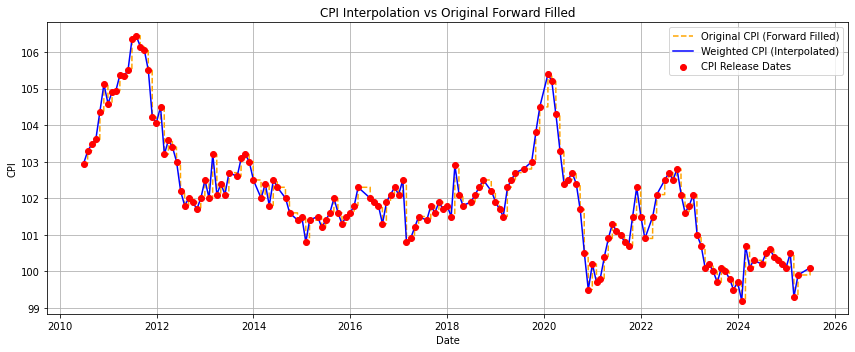

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 对比绘图
plt.plot(df["date"], df["CPI"], label="Original CPI (Forward Filled)", color="orange", linestyle="--")
plt.plot(df["date"], cpi_weighted, label="Weighted CPI (Interpolated)", color="blue")

# 标记 CPI 发布日
plt.scatter(release_dates, df.loc[df["date"].isin(release_dates), "CPI"], 
            color='red', label="CPI Release Dates", zorder=5)

plt.title("CPI Interpolation vs Original Forward Filled")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
df.head()

,date,reverse_repo_7d,reverse_repo_7d_amount,DXY,FR007,CPI_yoy,CPI_mom,CPI,PPI_yoy,PPI_mom,...,interbank,IBO001,IBO007,SHCOMP,R001,R007,ncd,ncd3m,ncd1y,CPI_weighted
0,2010-06-01,0.0,0.0,86.89,3.20,NaN,NaN,NaN,NaN,NaN,...,77.7,2.75,3.20,2568.28,2.74,3.19,NaN,NaN,NaN,NaN
1,2010-06-02,NaN,0.0,86.74,3.28,NaN,NaN,NaN,NaN,NaN,...,77.7,2.76,3.27,2571.42,2.76,3.28,NaN,NaN,NaN,NaN
2,2010-06-03,NaN,0.0,87.21,2.95,NaN,NaN,NaN,NaN,NaN,...,77.7,2.75,3.21,2552.66,2.74,3.15,NaN,NaN,NaN,NaN
3,2010-06-04,NaN,0.0,88.30,2.22,NaN,NaN,NaN,NaN,NaN,...,77.7,2.10,2.22,2553.59,2.10,2.21,NaN,NaN,NaN,NaN
4,2010-06-05,NaN,0.0,88.30,2.22,NaN,NaN,NaN,NaN,NaN,...,77.7,2.10,2.22,2553.59,2.10,2.21,NaN,NaN,NaN,NaN


In [10]:
# 计算距离月末的天数
df["days_to_month_end"] = (df["date"].dt.to_period("M").dt.end_time - df["date"]).dt.days

# 税期
tax_dates = [
    # 2014
    "2014-01-16", "2014-02-21", "2014-03-17", "2014-04-18", "2014-05-19", "2014-06-16",
    "2014-07-15", "2014-08-15", "2014-09-15", "2014-10-22", "2014-11-17", "2014-12-15",
    # 2015
    "2015-01-19", "2015-02-15", "2015-03-16", "2015-04-20", "2015-05-18", "2015-06-15",
    "2015-07-15", "2015-08-17", "2015-09-15", "2015-10-22", "2015-11-16", "2015-12-15",
    # 2016
    "2016-01-18", "2016-02-22", "2016-03-15", "2016-04-18", "2016-05-16", "2016-06-20",
    "2016-07-15", "2016-08-15", "2016-09-18", "2016-10-24", "2016-11-15", "2016-12-15",
    # 2017
    "2017-01-16", "2017-02-15", "2017-03-15", "2017-04-18", "2017-05-15", "2017-06-15",
    "2017-07-17", "2017-08-15", "2017-09-15", "2017-10-23", "2017-11-15", "2017-12-15",
    # 2018
    "2018-01-15", "2018-02-22", "2018-03-15", "2018-04-18", "2018-05-15", "2018-06-15",
    "2018-07-16", "2018-08-15", "2018-09-17", "2018-10-24", "2018-11-15", "2018-12-17",
    # 2019
    "2019-01-15", "2019-02-26", "2019-03-15", "2019-04-18", "2019-05-21", "2019-06-19",
    "2019-07-15", "2019-08-16", "2019-09-18", "2019-10-24", "2019-11-15", "2019-12-16",
    # 2020
    "2020-01-15", "2020-02-17", "2020-03-16", "2020-04-20", "2020-05-22", "2020-06-20",
    "2020-08-17", "2020-10-23", "2020-11-16",
    # 2021
    "2021-01-20", "2021-02-23", "2021-04-20", "2021-05-21", "2021-06-18", "2021-08-16", "2021-10-26", "2021-12-17",
    # 2022
    "2022-01-19", "2022-02-23", "2022-04-20", "2022-05-19", "2022-06-20", "2022-09-20", "2022-10-25", "2022-12-15",
    # 2023
    "2023-01-16", "2023-04-17", "2023-05-18", "2023-07-17", "2023-10-23",
    # 2024
    "2024-01-15", "2024-02-23", "2024-04-18", "2024-05-22", "2024-06-19", "2024-09-18", "2024-10-24", "2024-12-16",
    # 2025
    "2025-01-15", "2025-02-20", "2025-03-17", "2025-04-18", "2025-05-22", "2025-06-16",
    "2025-10-27", "2025-11-17"
]

# Step 3: 转换为日期并创建税期集合
tax_days = pd.to_datetime(tax_dates)
tax_day_set = set(tax_days)

# Step 4: 添加 is_taxday 列（税期=1，非税期=0）
df['is_taxday'] = df['date'].isin(tax_day_set).astype(int)

    
# 春节
# 每年春节（农历正月初一）对应的公历日期（来源：万年历）
spring_festival_dates = {
    2014: "2014-01-31",
    2015: "2015-02-19",
    2016: "2016-02-08",
    2017: "2017-01-28",
    2018: "2018-02-16",
    2019: "2019-02-05",
    2020: "2020-01-25",
    2021: "2021-02-12",
    2022: "2022-02-01",
    2023: "2023-01-22",
    2024: "2024-02-10",
    2025: "2025-01-29",
}

# 初始化春节前标记列
df["pre_spring_festival_flag"] = 0

# 遍历每年春节，标记春节前14天范围
for year, festival_date_str in spring_festival_dates.items():
    festival_date = pd.to_datetime(festival_date_str)
    pre_period_start = festival_date - pd.Timedelta(days=14)
    pre_period_end = festival_date - pd.Timedelta(days=1)
    
    mask = (df["date"] >= pre_period_start) & (df["date"] <= pre_period_end)
    df.loc[mask, "pre_spring_festival_flag"] = 1

# 初始化春节后标记列
df["post_spring_festival_flag"] = 0

# 遍历每年春节，标记节后14天
for year, festival_date_str in spring_festival_dates.items():
    festival_date = pd.to_datetime(festival_date_str)
    post_period_start = festival_date
    post_period_end = festival_date + pd.Timedelta(days=13)  # 共14天：0~13

    mask = (df["date"] >= post_period_start) & (df["date"] <= post_period_end)
    df.loc[mask, "post_spring_festival_flag"] = 1

In [11]:
df['3m1ydiff'] = df['ncd3m'] - df['ncd']

In [12]:
df.tail(50)

,date,reverse_repo_7d,reverse_repo_7d_amount,DXY,FR007,CPI_yoy,CPI_mom,CPI,PPI_yoy,PPI_mom,...,R007,ncd,ncd3m,ncd1y,CPI_weighted,days_to_month_end,is_taxday,pre_spring_festival_flag,post_spring_festival_flag,3m1ydiff
5469,2025-05-22,1.4,1545.0,99.94,1.58,0.014286,-0.112903,99.9,-3.125806,-0.4,...,1.58,1.69,NaN,NaN,100.014286,9,1,0,0,NaN
5470,2025-05-23,1.4,1425.0,99.12,1.63,0.016484,-0.122581,99.9,-3.145161,-0.4,...,1.63,1.70,NaN,NaN,100.016484,8,0,0,0,NaN
5471,2025-05-24,1.4,1425.0,99.12,1.63,0.018681,-0.132258,99.9,-3.164516,-0.4,...,1.63,1.70,NaN,NaN,100.018681,7,0,0,0,NaN
5472,2025-05-25,1.4,1425.0,99.12,1.63,0.020879,-0.141935,99.9,-3.183871,-0.4,...,1.63,1.70,NaN,NaN,100.020879,6,0,0,0,NaN
5473,2025-05-26,1.4,3820.0,98.99,1.70,0.023077,-0.151613,99.9,-3.203226,-0.4,...,1.70,1.70,NaN,NaN,100.023077,5,0,0,0,NaN
5474,2025-05-27,1.4,4480.0,99.57,1.70,0.025275,-0.161290,99.9,-3.222581,-0.4,...,1.68,1.71,NaN,NaN,100.025275,4,0,0,0,NaN
5475,2025-05-28,1.4,2155.0,99.87,1.70,0.027473,-0.170968,99.9,-3.241935,-0.4,...,1.69,1.71,NaN,NaN,100.027473,3,0,0,0,NaN
5476,2025-05-29,1.4,2660.0,99.33,1.75,0.029670,-0.180645,99.9,-3.261290,-0.4,...,1.74,1.72,NaN,NaN,100.029670,2,0,0,0,NaN
5477,2025-05-30,1.4,2911.0,99.44,1.75,0.031868,-0.190323,99.9,-3.280645,-0.4,...,1.70,1.71,NaN,NaN,100.031868,1,0,0,0,NaN
5478,2025-05-31,1.4,2911.0,99.44,1.75,0.034066,-0.200000,99.9,-3.300000,-0.4,...,1.70,1.71,NaN,NaN,100.034066,0,0,0,0,NaN


In [13]:
df.iloc[3150:3200]

,date,reverse_repo_7d,reverse_repo_7d_amount,DXY,FR007,CPI_yoy,CPI_mom,CPI,PPI_yoy,PPI_mom,...,R007,ncd,ncd3m,ncd1y,CPI_weighted,days_to_month_end,is_taxday,pre_spring_festival_flag,post_spring_festival_flag,3m1ydiff
3150,2019-01-15,2.55,1800.0,95.96,2.65,1.801935,0.241935,101.9,0.512903,-0.806452,...,2.79,3.11,3.2011,3.2800,101.803226,16,1,0,0,0.0911
3151,2019-01-16,2.55,5700.0,96.11,2.66,1.798065,0.258065,101.9,0.487097,-0.793548,...,2.69,3.11,3.2189,3.2801,101.796774,15,0,0,0,0.1089
3152,2019-01-17,2.55,4000.0,96.08,2.60,1.794194,0.274194,101.9,0.461290,-0.780645,...,2.56,3.08,3.2067,3.2500,101.790323,14,0,0,0,0.1267
3153,2019-01-18,2.55,200.0,96.37,2.60,1.790323,0.290323,101.9,0.435484,-0.767742,...,2.55,3.08,3.2167,3.2800,101.783871,13,0,0,0,0.1367
3154,2019-01-19,2.55,200.0,96.37,2.60,1.786452,0.306452,101.9,0.409677,-0.754839,...,2.55,3.08,3.2144,3.3000,101.777419,12,0,0,0,0.1344
3155,2019-01-20,2.55,200.0,96.37,2.60,1.782581,0.322581,101.9,0.383871,-0.741935,...,2.55,3.08,3.1865,3.3100,101.770968,11,0,0,0,0.1065
3156,2019-01-21,2.55,0.0,96.34,2.57,1.778710,0.338710,101.9,0.358065,-0.729032,...,2.56,3.11,3.0598,3.2500,101.764516,10,0,0,0,-0.0502
3157,2019-01-22,2.55,0.0,96.32,2.55,1.774839,0.354839,101.9,0.332258,-0.716129,...,2.57,3.10,3.0101,3.1903,101.758065,9,0,1,0,-0.0899
3158,2019-01-23,2.55,0.0,96.14,2.59,1.770968,0.370968,101.9,0.306452,-0.703226,...,2.60,3.09,3.0351,3.1900,101.751613,8,0,1,0,-0.0549
3159,2019-01-24,2.55,0.0,96.54,2.60,1.767097,0.387097,101.9,0.280645,-0.690323,...,2.59,3.09,3.0610,3.2104,101.745161,7,0,1,0,-0.0290


In [14]:
df.isna().sum()

date                            0
reverse_repo_7d               701
reverse_repo_7d_amount          0
DXY                             0
FR007                           0
CPI_yoy                        29
CPI_mom                        29
CPI                            29
PPI_yoy                        29
PPI_mom                        29
house_listing_index            29
PMI                            29
tsf                             0
trust_loan                      0
m1_yoy                         29
m2_yoy                         29
tsf_yoy                       213
Shibor                          0
central_bank_bill               3
ncd_amount                   1644
interbank                       0
IBO001                          0
IBO007                          0
SHCOMP                          0
R001                            0
R007                            0
ncd                          1291
ncd3m                        2897
ncd1y                        2897
CPI_weighted  

In [15]:
# 根据收益率计算其他因子
## cntn
df["ncd"] = pd.to_numeric(df["ncd"], errors="coerce")
# 收益率差分
df["ncd_diff"] = df["ncd"].diff()
# cntn(30): 最近30天收益率变化<0的天数占比
df["cntn_30"] = (
    df["ncd_diff"]
    .rolling(30)
    .apply(lambda x: (x < 0).mean(), raw=True)
)

In [16]:
# 反转趋势因子
def compute_imax(series, window=20):
    """
    计算 imax：当前日与过去 window 日内最高值所在位置的间隔天数。
    越小表示刚创新高，越大表示已远离高点。
    """
    imax_list = []
    for i in range(len(series)):
        if i < window:
            imax_list.append(np.nan)
        else:
            window_slice = series[i - window:i]
            if window_slice.isna().all():
                imax_list.append(np.nan)
            else:
                max_idx = window_slice.idxmax()
                # 改这里：用位置差计算天数
                days_since_high = i - 1 - max_idx
                imax_list.append(days_since_high)
    return pd.Series(imax_list, index=series.index)

df["imax_20"] = compute_imax(df["ncd"], window=20)

In [17]:
def compute_atr(series, window=14):
    """
    用 ncd 的绝对变化近似真实波幅
    """
    true_range = series.diff().abs()
    atr = true_range.rolling(window=window).mean()
    return atr

df["atr_14"] = compute_atr(df["ncd"], window=14)

In [18]:
def compute_qtlu(series, window=30, quantile=0.8):
    """
    计算过去 window 日的 quantile 分位点（当前为 80%）
    """
    return series.rolling(window=window).quantile(quantile)

# 构造 qtlu: ncd 的过去30日 80%分位点
df["qtlu_30"] = compute_qtlu(df["ncd"], window=30, quantile=0.8)

In [19]:
def compute_qtld(series, window=30, quantile=0.2):
    """
    计算过去 window 日的 quantile 分位点（默认 20%）
    """
    return series.rolling(window=window).quantile(quantile)

# 构造 qtld: ncd 的过去30日 20%分位点
df["qtld_30"] = compute_qtld(df["ncd"], window=30, quantile=0.2)

In [20]:
df.head(50)

,date,reverse_repo_7d,reverse_repo_7d_amount,DXY,FR007,CPI_yoy,CPI_mom,CPI,PPI_yoy,PPI_mom,...,is_taxday,pre_spring_festival_flag,post_spring_festival_flag,3m1ydiff,ncd_diff,cntn_30,imax_20,atr_14,qtlu_30,qtld_30
0,2010-06-01,0.0,0.0,86.89,3.20,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-06-02,NaN,0.0,86.74,3.28,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-06-03,NaN,0.0,87.21,2.95,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-06-04,NaN,0.0,88.30,2.22,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-06-05,NaN,0.0,88.30,2.22,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2010-06-06,NaN,0.0,88.30,2.22,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2010-06-07,NaN,0.0,88.48,1.93,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2010-06-08,NaN,0.0,88.15,2.19,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2010-06-09,NaN,0.0,87.92,2.21,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2010-06-10,NaN,0.0,87.13,2.47,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# 去除所有含NaN的行
data = df.dropna().copy()
# 重置索引
data.reset_index(drop=True, inplace=True)
data.head(50)

,date,reverse_repo_7d,reverse_repo_7d_amount,DXY,FR007,CPI_yoy,CPI_mom,CPI,PPI_yoy,PPI_mom,...,is_taxday,pre_spring_festival_flag,post_spring_festival_flag,3m1ydiff,ncd_diff,cntn_30,imax_20,atr_14,qtlu_30,qtld_30
0,2015-01-04,4.10,0.0,91.16,4.89,1.413226,0.294839,101.5,-3.449032,-0.664516,...,0,0,0,0.3455,0.00,0.366667,17.0,0.020000,4.760,4.540
1,2015-01-05,4.10,0.0,91.43,4.49,1.389032,0.293548,101.5,-3.481290,-0.680645,...,0,0,0,0.3336,-0.01,0.400000,18.0,0.013571,4.760,4.540
2,2015-01-06,4.10,0.0,91.61,4.06,1.364839,0.292258,101.5,-3.513548,-0.696774,...,0,0,0,0.3473,-0.06,0.433333,19.0,0.014286,4.760,4.540
3,2015-01-07,4.10,0.0,91.99,3.87,1.340645,0.290968,101.5,-3.545806,-0.712903,...,0,0,0,0.3532,-0.01,0.466667,19.0,0.012143,4.760,4.540
4,2015-01-08,4.10,0.0,92.30,3.74,1.316452,0.289677,101.5,-3.578065,-0.729032,...,0,0,0,0.3463,-0.01,0.500000,19.0,0.011429,4.728,4.540
5,2015-01-09,4.10,0.0,91.94,3.80,1.292258,0.288387,101.5,-3.610323,-0.745161,...,0,0,0,0.3301,-0.01,0.533333,19.0,0.010714,4.712,4.540
6,2015-01-10,4.10,0.0,91.94,3.80,1.268065,0.287097,101.5,-3.642581,-0.761290,...,0,0,0,0.3060,0.00,0.500000,19.0,0.010714,4.712,4.538
7,2015-01-11,4.10,0.0,91.94,3.80,1.243871,0.285806,101.5,-3.674839,-0.777419,...,0,0,0,0.2393,0.00,0.500000,19.0,0.010714,4.712,4.518
8,2015-01-12,4.10,0.0,92.04,3.82,1.219677,0.284516,101.5,-3.707097,-0.793548,...,0,0,0,0.2028,-0.02,0.533333,19.0,0.010714,4.712,4.468
9,2015-01-13,4.10,0.0,92.28,3.84,1.195484,0.283226,101.5,-3.739355,-0.809677,...,0,0,0,0.1013,-0.03,0.566667,19.0,0.011429,4.712,4.458


In [22]:
data.isna().sum()

date                         0
reverse_repo_7d              0
reverse_repo_7d_amount       0
DXY                          0
FR007                        0
CPI_yoy                      0
CPI_mom                      0
CPI                          0
PPI_yoy                      0
PPI_mom                      0
house_listing_index          0
PMI                          0
tsf                          0
trust_loan                   0
m1_yoy                       0
m2_yoy                       0
tsf_yoy                      0
Shibor                       0
central_bank_bill            0
ncd_amount                   0
interbank                    0
IBO001                       0
IBO007                       0
SHCOMP                       0
R001                         0
R007                         0
ncd                          0
ncd3m                        0
ncd1y                        0
CPI_weighted                 0
days_to_month_end            0
is_taxday                    0
pre_spri

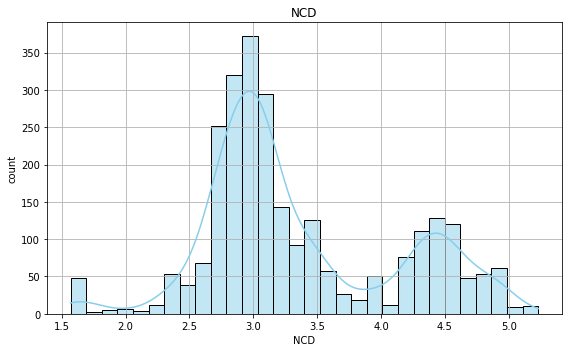

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 画图
plt.figure(figsize=(8, 5))
sns.histplot(data["ncd"], bins=30, kde=True, color="skyblue", edgecolor="black")

plt.title("NCD")
plt.xlabel("NCD")
plt.ylabel("count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
'''
import matplotlib.pyplot as plt
import seaborn as sns

# 画图
plt.figure(figsize=(8, 5))
sns.histplot(data["log_ncd_next_week"], bins=30, kde=True, color="skyblue", edgecolor="black")

plt.title("NCD")
plt.xlabel("NCD")
plt.ylabel("count")
plt.grid(True)
plt.tight_layout()
plt.show()
'''

'\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# 画图\nplt.figure(figsize=(8, 5))\nsns.histplot(data["log_ncd_next_week"], bins=30, kde=True, color="skyblue", edgecolor="black")\n\nplt.title("NCD")\nplt.xlabel("NCD")\nplt.ylabel("count")\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n'

In [25]:
data.columns

Index(['date', 'reverse_repo_7d', 'reverse_repo_7d_amount', 'DXY', 'FR007',
       'CPI_yoy', 'CPI_mom', 'CPI', 'PPI_yoy', 'PPI_mom',
       'house_listing_index', 'PMI', 'tsf', 'trust_loan', 'm1_yoy', 'm2_yoy',
       'tsf_yoy', 'Shibor', 'central_bank_bill', 'ncd_amount', 'interbank',
       'IBO001', 'IBO007', 'SHCOMP', 'R001', 'R007', 'ncd', 'ncd3m', 'ncd1y',
       'CPI_weighted', 'days_to_month_end', 'is_taxday',
       'pre_spring_festival_flag', 'post_spring_festival_flag', '3m1ydiff',
       'ncd_diff', 'cntn_30', 'imax_20', 'atr_14', 'qtlu_30', 'qtld_30'],
      dtype='object')

In [26]:
# 创建一个月之后的ncd
data['ncd_next_month'] = data["ncd"].shift(-30)
data = data.dropna().reset_index(drop=True)
data.head(35)

,date,reverse_repo_7d,reverse_repo_7d_amount,DXY,FR007,CPI_yoy,CPI_mom,CPI,PPI_yoy,PPI_mom,...,pre_spring_festival_flag,post_spring_festival_flag,3m1ydiff,ncd_diff,cntn_30,imax_20,atr_14,qtlu_30,qtld_30,ncd_next_month
0,2015-01-04,4.10,0.0,91.16,4.89,1.413226,0.294839,101.5,-3.449032,-0.664516,...,0,0,0.3455,0.00,0.366667,17.0,0.020000,4.760,4.540,4.45
1,2015-01-05,4.10,0.0,91.43,4.49,1.389032,0.293548,101.5,-3.481290,-0.680645,...,0,0,0.3336,-0.01,0.400000,18.0,0.013571,4.760,4.540,4.46
2,2015-01-06,4.10,0.0,91.61,4.06,1.364839,0.292258,101.5,-3.513548,-0.696774,...,0,0,0.3473,-0.06,0.433333,19.0,0.014286,4.760,4.540,4.36
3,2015-01-07,4.10,0.0,91.99,3.87,1.340645,0.290968,101.5,-3.545806,-0.712903,...,0,0,0.3532,-0.01,0.466667,19.0,0.012143,4.760,4.540,4.37
4,2015-01-08,4.10,0.0,92.30,3.74,1.316452,0.289677,101.5,-3.578065,-0.729032,...,0,0,0.3463,-0.01,0.500000,19.0,0.011429,4.728,4.540,4.37
5,2015-01-09,4.10,0.0,91.94,3.80,1.292258,0.288387,101.5,-3.610323,-0.745161,...,0,0,0.3301,-0.01,0.533333,19.0,0.010714,4.712,4.540,4.37
6,2015-01-10,4.10,0.0,91.94,3.80,1.268065,0.287097,101.5,-3.642581,-0.761290,...,0,0,0.3060,0.00,0.500000,19.0,0.010714,4.712,4.538,4.36
7,2015-01-11,4.10,0.0,91.94,3.80,1.243871,0.285806,101.5,-3.674839,-0.777419,...,0,0,0.2393,0.00,0.500000,19.0,0.010714,4.712,4.518,4.34
8,2015-01-12,4.10,0.0,92.04,3.82,1.219677,0.284516,101.5,-3.707097,-0.793548,...,0,0,0.2028,-0.02,0.533333,19.0,0.010714,4.712,4.468,4.30
9,2015-01-13,4.10,0.0,92.28,3.84,1.195484,0.283226,101.5,-3.739355,-0.809677,...,0,0,0.1013,-0.03,0.566667,19.0,0.011429,4.712,4.458,4.27


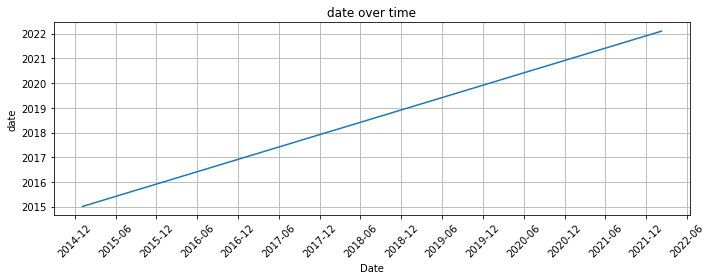

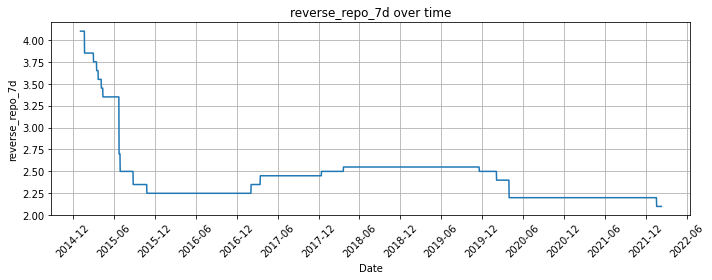

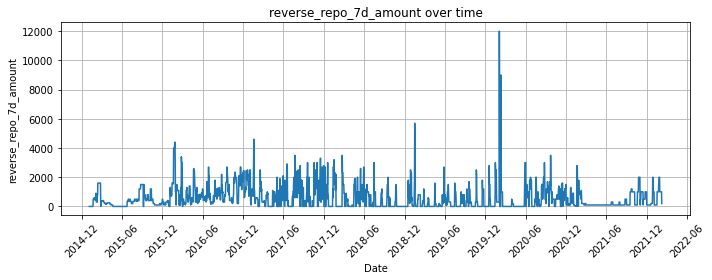

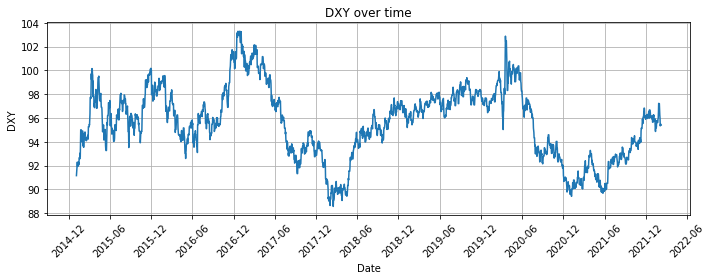

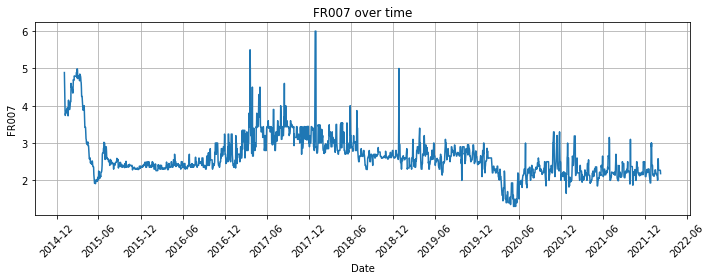

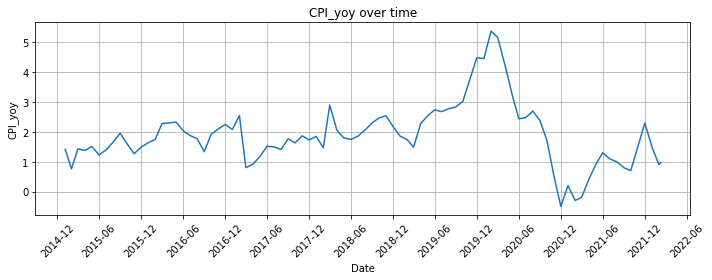

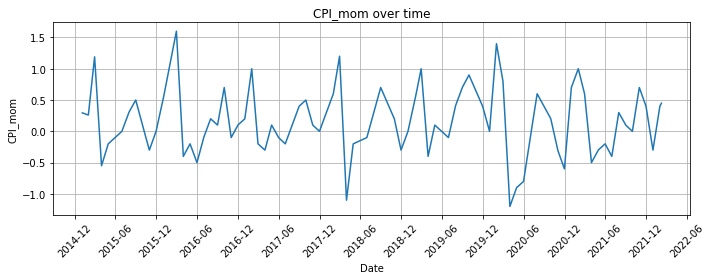

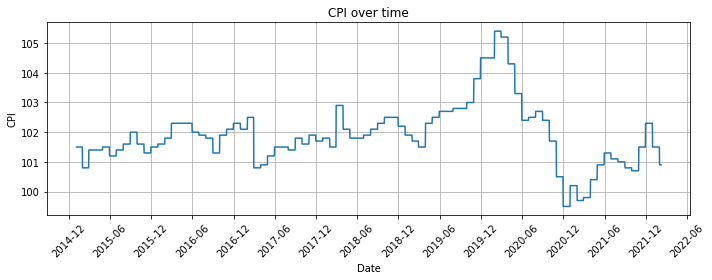

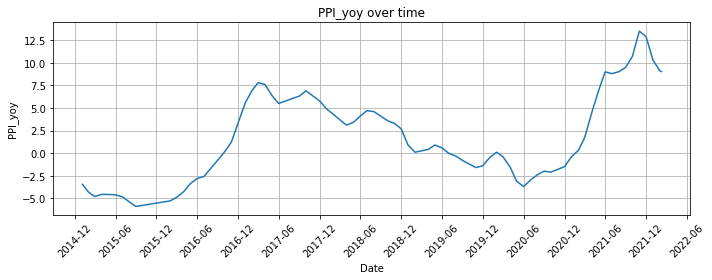

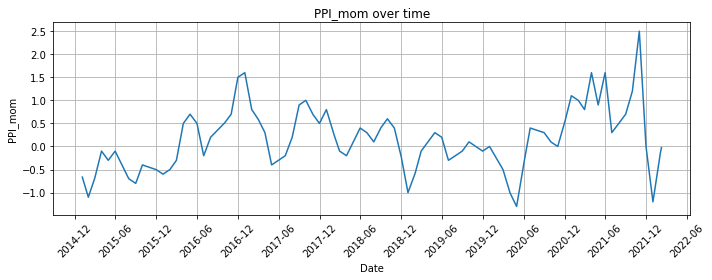

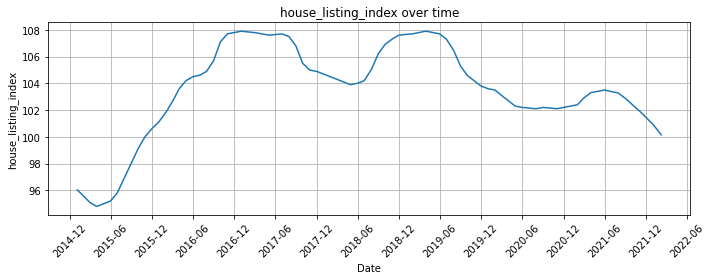

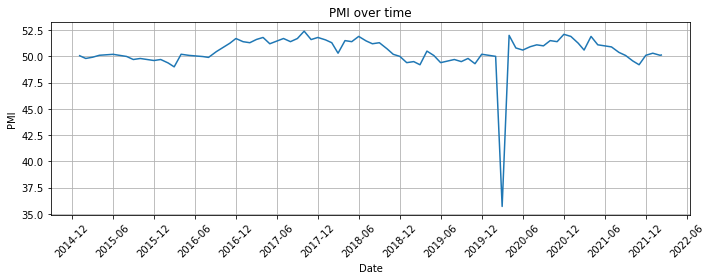

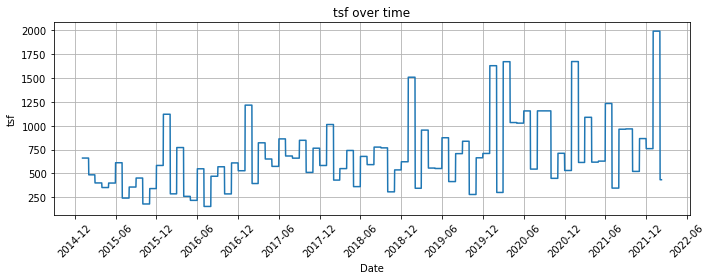

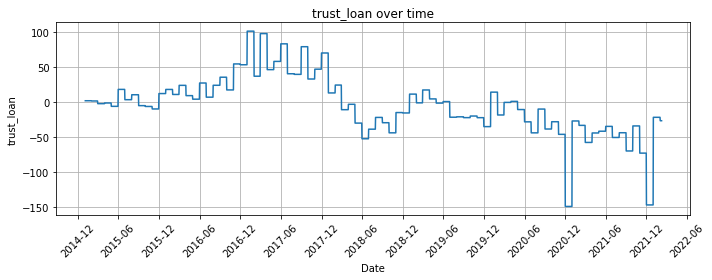

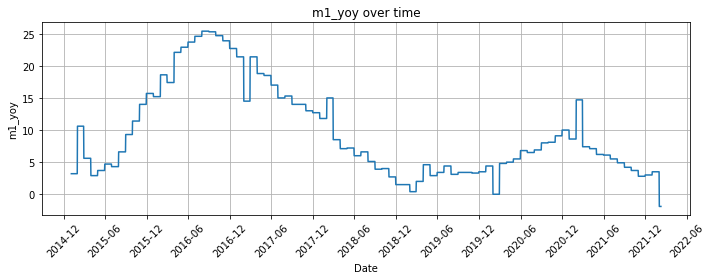

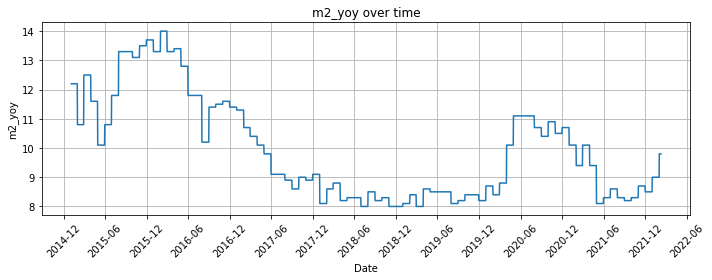

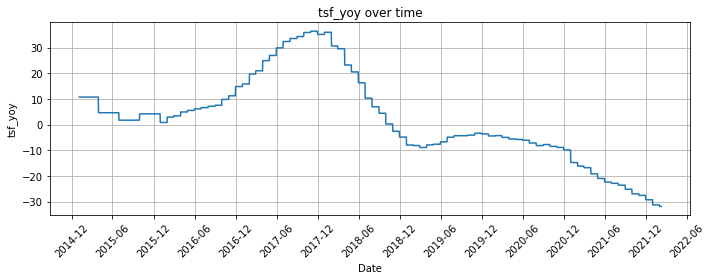

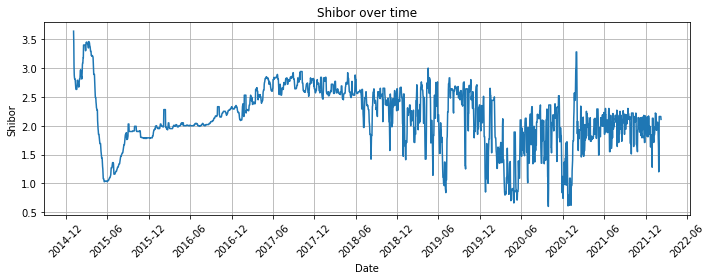

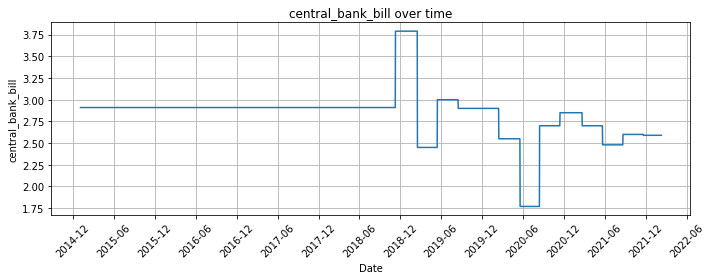

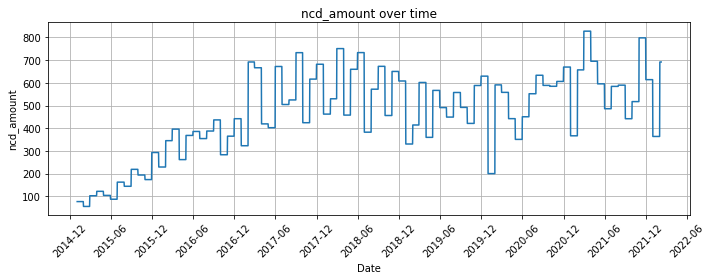

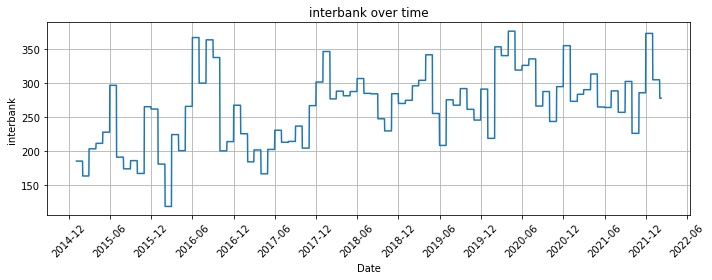

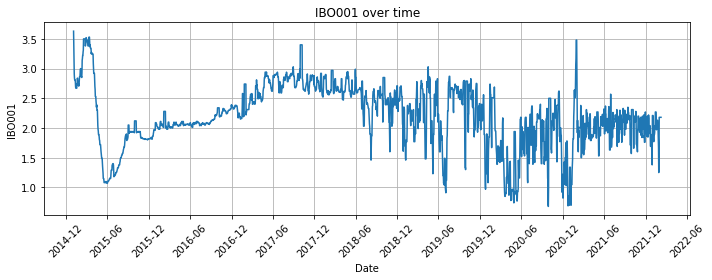

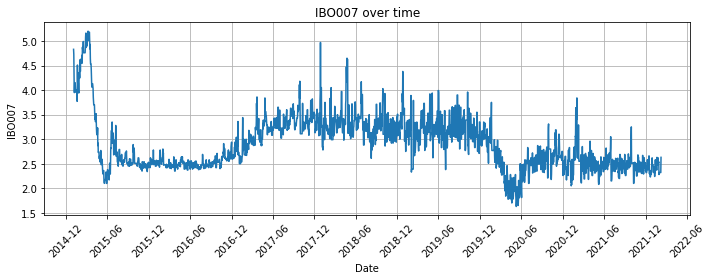

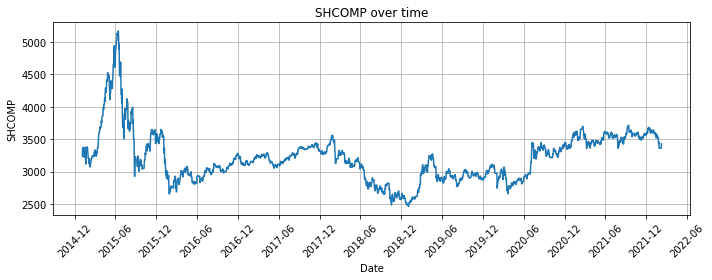

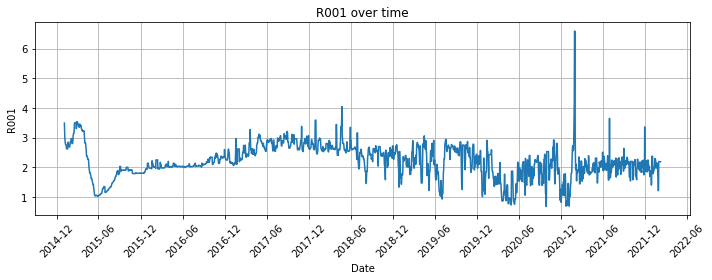

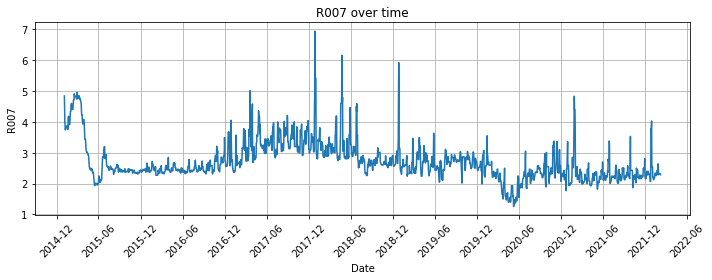

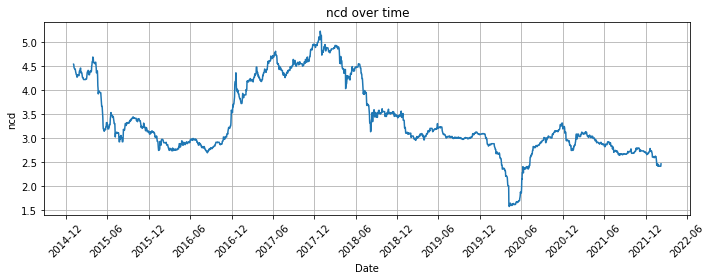

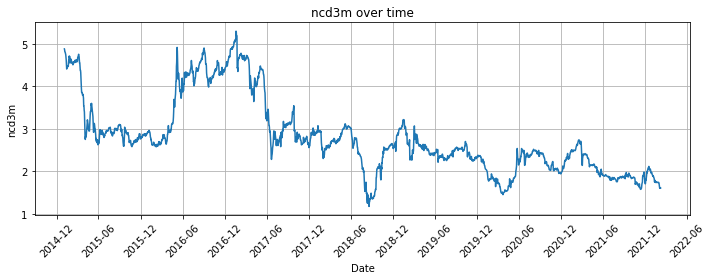

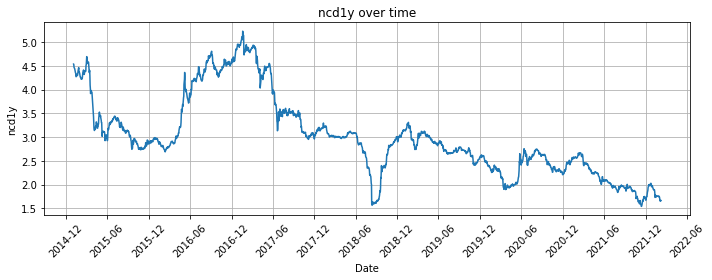

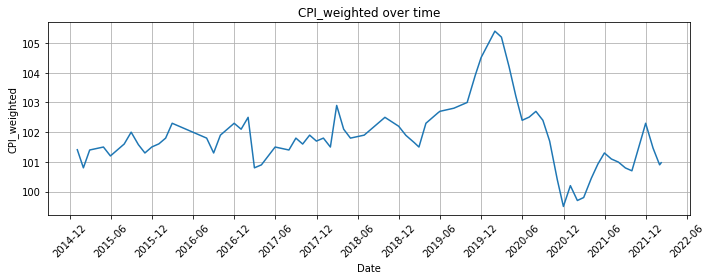

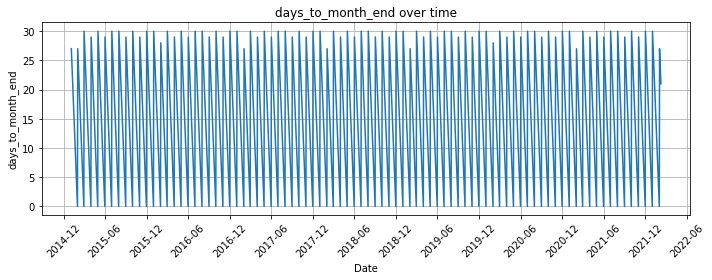

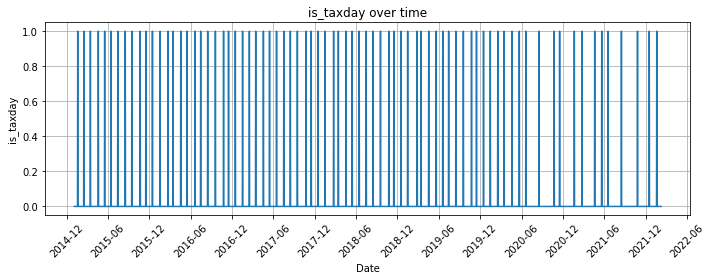

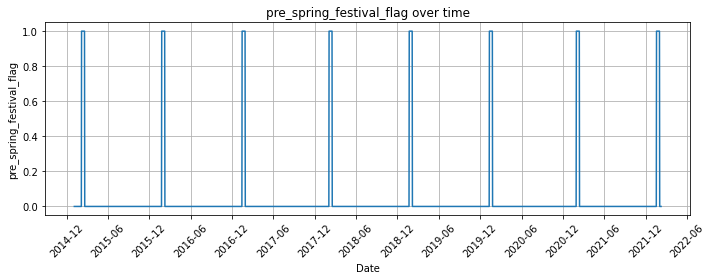

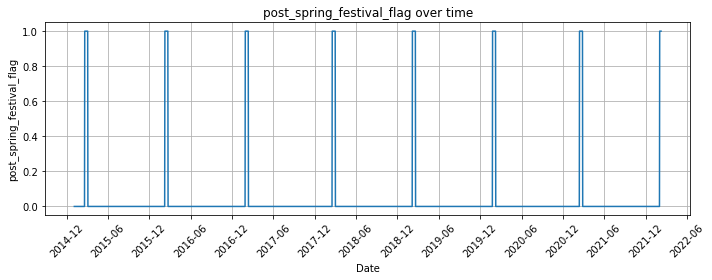

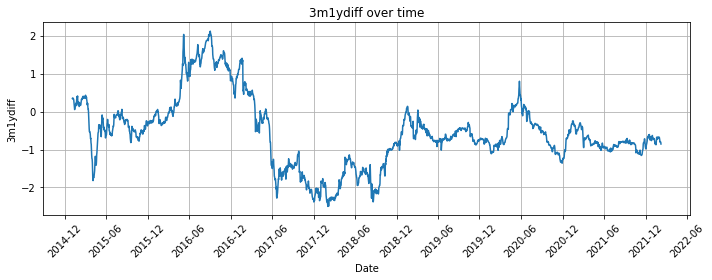

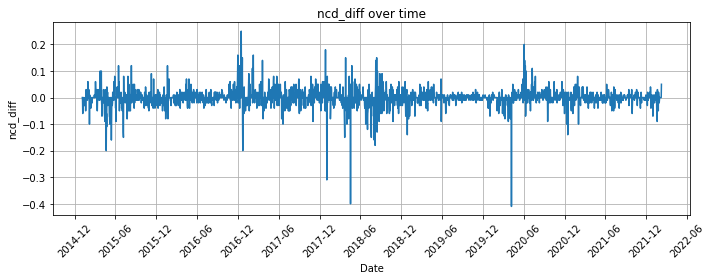

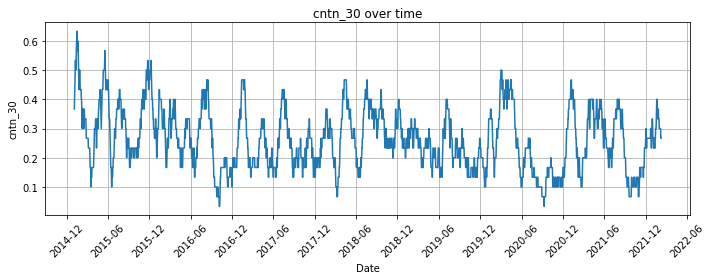

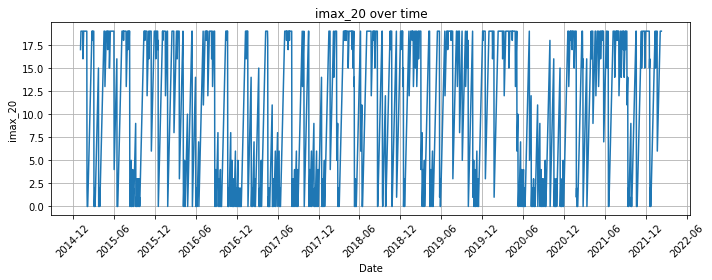

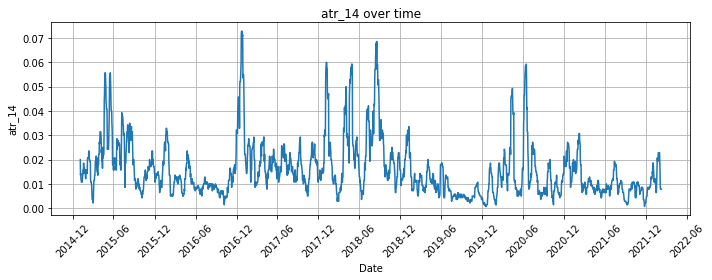

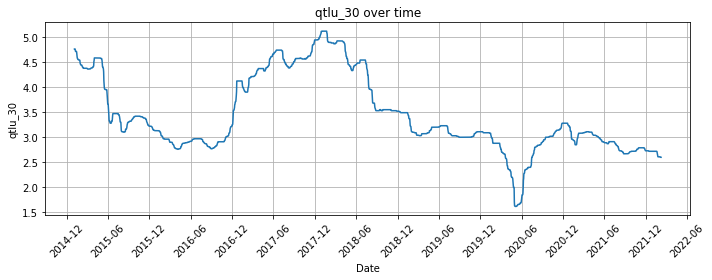

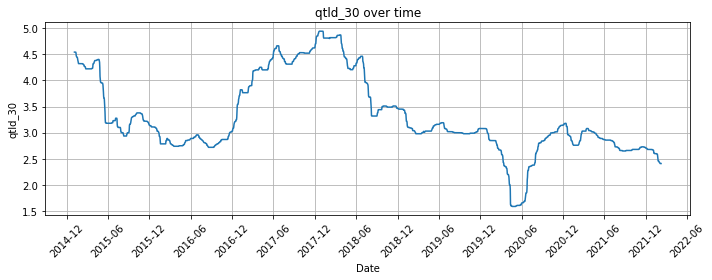

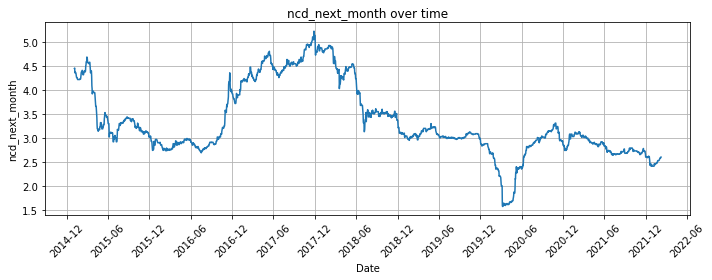

In [27]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# 设置每年6月和12月显示一次
locator = mdates.MonthLocator(bymonth=[6, 12])
formatter = mdates.DateFormatter('%Y-%m')

for col in data.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(data['date'], data[col])
    plt.title(f"{col} over time")
    plt.xlabel("Date")
    plt.ylabel(col)

    ax = plt.gca()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [28]:
data.columns

Index(['date', 'reverse_repo_7d', 'reverse_repo_7d_amount', 'DXY', 'FR007',
       'CPI_yoy', 'CPI_mom', 'CPI', 'PPI_yoy', 'PPI_mom',
       'house_listing_index', 'PMI', 'tsf', 'trust_loan', 'm1_yoy', 'm2_yoy',
       'tsf_yoy', 'Shibor', 'central_bank_bill', 'ncd_amount', 'interbank',
       'IBO001', 'IBO007', 'SHCOMP', 'R001', 'R007', 'ncd', 'ncd3m', 'ncd1y',
       'CPI_weighted', 'days_to_month_end', 'is_taxday',
       'pre_spring_festival_flag', 'post_spring_festival_flag', '3m1ydiff',
       'ncd_diff', 'cntn_30', 'imax_20', 'atr_14', 'qtlu_30', 'qtld_30',
       'ncd_next_month'],
      dtype='object')

In [29]:
# 相关性检验
feature_cols = [col for col in data.columns if col not in ["date", 'ncd',"log_ncd", 'ncd_diff','CPI']]

# Pearson
pearson_corr = data[feature_cols].corr()["ncd_next_month"]

# Spearman
spearman_corr = data[feature_cols].corr(method="spearman")["ncd_next_month"]

print("Pearson相关系数：")
print(pearson_corr)

print("\nSpearman相关系数：")
print(spearman_corr)

print('*' * 100)

# 阈值
threshold = 0.01

# 筛选
selected_pearson = pearson_corr[pearson_corr.abs() > threshold].index.tolist()
selected_spearman = spearman_corr[spearman_corr.abs() > threshold].index.tolist()

# 去掉ncd_tomorrow本身
# selected_pearson = [f for f in selected_pearson if f != "ncd_next_week"]
# selected_spearman = [f for f in selected_spearman if f != "ncd_next_week"]

print("Pearson筛选出的因子：", selected_pearson)
print("Spearman筛选出的因子：", selected_spearman)
print('*' * 100)

# 取交集
final_factors = list(set(selected_pearson) & set(selected_spearman))
print("最终筛选因子：", final_factors)

Pearson相关系数：
reverse_repo_7d              0.367929
reverse_repo_7d_amount       0.124468
DXY                         -0.147238
FR007                        0.743276
CPI_yoy                     -0.241941
CPI_mom                      0.095657
PPI_yoy                      0.257466
PPI_mom                      0.164564
house_listing_index          0.190714
PMI                          0.440457
tsf                         -0.214931
trust_loan                   0.518045
m1_yoy                       0.294488
m2_yoy                      -0.094775
tsf_yoy                      0.827804
Shibor                       0.667936
central_bank_bill            0.299092
ncd_amount                   0.048919
interbank                   -0.385860
IBO001                       0.670456
IBO007                       0.653798
SHCOMP                       0.085277
R001                         0.635623
R007                         0.714746
ncd3m                        0.461374
ncd1y                        0.529143

In [30]:
# 计算Spearman IC
from scipy.stats import spearmanr

print("未来1月IC：")
for f in feature_cols:
    valid_idx = data[[f, "ncd_next_month"]].dropna().index
    ic = spearmanr(
        data.loc[valid_idx, f],
        data.loc[valid_idx, "ncd_next_month"]
    ).correlation
    print(f"{f}: IC = {ic:.4f}")

未来1月IC：
reverse_repo_7d: IC = 0.5561
reverse_repo_7d_amount: IC = 0.0303
DXY: IC = -0.0885
FR007: IC = 0.7556
CPI_yoy: IC = -0.1269
CPI_mom: IC = 0.0601
PPI_yoy: IC = 0.1697
PPI_mom: IC = 0.1167
house_listing_index: IC = 0.3565
PMI: IC = 0.4601
tsf: IC = -0.1707
trust_loan: IC = 0.4546
m1_yoy: IC = 0.2621
m2_yoy: IC = -0.0442
tsf_yoy: IC = 0.7555
Shibor: IC = 0.6412
central_bank_bill: IC = 0.5492
ncd_amount: IC = 0.0440
interbank: IC = -0.4122
IBO001: IC = 0.6394
IBO007: IC = 0.6961
SHCOMP: IC = 0.0636
R001: IC = 0.6209
R007: IC = 0.7250
ncd3m: IC = 0.5410
ncd1y: IC = 0.6017
CPI_weighted: IC = -0.1227
days_to_month_end: IC = -0.0139
is_taxday: IC = 0.0130
pre_spring_festival_flag: IC = -0.0112
post_spring_festival_flag: IC = 0.0094
3m1ydiff: IC = -0.2821
cntn_30: IC = -0.0366
imax_20: IC = -0.2056
atr_14: IC = 0.3754
qtlu_30: IC = 0.8945
qtld_30: IC = 0.8889
ncd_next_month: IC = 1.0000


In [31]:
# 提取 IC值筛选过的因子DataFrame
X_final = data[final_factors]

# 计算相关矩阵
corr_matrix = X_final.corr()

# 打印
print(corr_matrix)

                             FR007    Shibor  house_listing_index  \
FR007                     1.000000  0.745476             0.023282   
Shibor                    0.745476  1.000000             0.265581   
house_listing_index       0.023282  0.265581             1.000000   
days_to_month_end        -0.108421 -0.027710            -0.002678   
central_bank_bill         0.302247  0.238653             0.197914   
m2_yoy                   -0.062480 -0.201888            -0.446530   
imax_20                  -0.178297 -0.219659            -0.124956   
PPI_mom                  -0.055146  0.115415             0.337817   
R007                      0.944291  0.728843             0.030673   
CPI_yoy                  -0.125114 -0.077514             0.188361   
R001                      0.742840  0.964470             0.267953   
PMI                       0.179100  0.229173             0.162717   
tsf                      -0.180758 -0.143298             0.079636   
ncd_amount               -0.107738

In [32]:
# 存储高相关因子对
high_corr_pairs = []

print("\n以下因子对相关系数 > 0.8：")
for i in range(len(final_factors)):
    for j in range(i+1, len(final_factors)):
        f1 = final_factors[i]
        f2 = final_factors[j]
        corr_ij = corr_matrix.loc[f1, f2]
        if abs(corr_ij) > 0.8:
            print(f"  {f1} 与 {f2} 的相关系数 = {corr_ij:.4f}")
            high_corr_pairs.append((f1, f2, corr_ij))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=["factor_1", "factor_2", "correlation"])


以下因子对相关系数 > 0.8：
  FR007 与 R007 的相关系数 = 0.9443
  FR007 与 IBO007 的相关系数 = 0.8595
  Shibor 与 R001 的相关系数 = 0.9645
  Shibor 与 IBO001 的相关系数 = 0.9968
  R007 与 IBO007 的相关系数 = 0.8602
  CPI_yoy 与 CPI_weighted 的相关系数 = 0.9986
  R001 与 IBO001 的相关系数 = 0.9690
  tsf_yoy 与 ncd_next_month 的相关系数 = 0.8278
  qtlu_30 与 qtld_30 的相关系数 = 0.9866
  qtlu_30 与 ncd_next_month 的相关系数 = 0.9064
  ncd3m 与 ncd1y 的相关系数 = 0.9743
  qtld_30 与 ncd_next_month 的相关系数 = 0.9119


In [33]:
# 要剔除的变量
target_col = ['ncd_next_month']
manual_remove = ['ncd1y','ncd3m','CPI_yoy','qtld_30','IBO007','R007','R001','IBO001']
# manual_remove = ['CPI_yoy', 'R001','IBO001','FR007','qtlu_30','reverse_repo_7d','DR007','DR001','IBO007']

# 过滤变量名
final_factors_no_collinearity = [col for col in final_factors if col not in manual_remove + target_col]

# 显示结果
print("最终因子数量：", len(final_factors_no_collinearity))
print("最终因子列表：", final_factors_no_collinearity)

最终因子数量： 28
最终因子列表： ['FR007', 'Shibor', 'house_listing_index', 'days_to_month_end', 'central_bank_bill', 'm2_yoy', 'imax_20', 'PPI_mom', 'PMI', 'tsf', 'ncd_amount', 'tsf_yoy', 'qtlu_30', 'trust_loan', '3m1ydiff', 'interbank', 'SHCOMP', 'PPI_yoy', 'CPI_mom', 'cntn_30', 'reverse_repo_7d_amount', 'is_taxday', 'CPI_weighted', 'm1_yoy', 'DXY', 'reverse_repo_7d', 'pre_spring_festival_flag', 'atr_14']


In [34]:
# 存储高相关因子对
high_corr_pairs = []

print("\n以下因子对相关系数 > 0.8：")
for i in range(len(final_factors_no_collinearity)):
    for j in range(i+1, len(final_factors_no_collinearity)):
        f1 = final_factors_no_collinearity[i]
        f2 = final_factors_no_collinearity[j]
        corr_ij = corr_matrix.loc[f1, f2]
        if abs(corr_ij) > 0.8:
            print(f"  {f1} 与 {f2} 的相关系数 = {corr_ij:.4f}")
            high_corr_pairs.append((f1, f2, corr_ij))

# 可选：将结果保存为 DataFrame 以便导出或排序
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["factor_1", "factor_2", "correlation"])


以下因子对相关系数 > 0.8：


In [56]:
# 差值
data["ncd_diff_month"] = data["ncd_next_month"] - data["ncd"]

# 阈值
epsilon = 0.005

# 分类标签
def classify(x):
    if x > epsilon:
        return 1
    elif x <= -epsilon:
        return 0

data["ncd_label"] = data["ncd_diff_month"].apply(classify)

# 看分布
print(data["ncd_label"].value_counts())

# 去除Na值
# data = data.dropna().reset_index(drop=True)

ncd_label
0    1287
1    1234
Name: count, dtype: int64


In [57]:
class Para:
    percent_cv = 0.2
    percent_train = 0.8
    seed = 42

In [58]:
data.columns

Index(['date', 'reverse_repo_7d', 'reverse_repo_7d_amount', 'DXY', 'FR007',
       'CPI_yoy', 'CPI_mom', 'CPI', 'PPI_yoy', 'PPI_mom',
       'house_listing_index', 'PMI', 'tsf', 'trust_loan', 'm1_yoy', 'm2_yoy',
       'tsf_yoy', 'Shibor', 'central_bank_bill', 'ncd_amount', 'interbank',
       'IBO001', 'IBO007', 'SHCOMP', 'R001', 'R007', 'ncd', 'ncd3m', 'ncd1y',
       'CPI_weighted', 'days_to_month_end', 'is_taxday',
       'pre_spring_festival_flag', 'post_spring_festival_flag', '3m1ydiff',
       'ncd_diff', 'cntn_30', 'imax_20', 'atr_14', 'qtlu_30', 'qtld_30',
       'ncd_next_month', 'ncd_diff_month', 'ncd_label'],
      dtype='object')

In [59]:
# x和y
x = data[final_factors_no_collinearity]
y = data["ncd_label"]

# 按行数切分
train_size = int(len(data) * Para.percent_train)

x_train = x.iloc[:train_size]
x_test = x.iloc[train_size:]

y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

# 初始化变换器（强制正态分布）
# qt = QuantileTransformer(output_distribution='normal', random_state=42)

# 拟合 y_train 并对 y_train/y_test 做正态映射
# y_train_normal = qt.fit_transform(y_train.values.reshape(-1, 1)).ravel()
# y_test_normal = qt.transform(y_test.values.reshape(-1, 1)).ravel()

# Apply Genetic Programming
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv']
gp = SymbolicTransformer(
    generations=10,               # 进化代数 (减少以便演示)
    population_size=1000,          # 种群大小 (减少以便演示)
    hall_of_fame=200,              # 荣誉堂：保留多少个历史上最优秀的公式
    n_components=10,               # 最终希望得到多少个最优的新特征
    function_set=function_set,    # 允许使用的数学函数
    parsimony_coefficient=0.0005, # 节俭系数：一个惩罚项，防止公式变得过于复杂
    max_samples=0.8,              # 每次评估时使用的样本比例，增加随机性
    verbose=1,                    # 打印进化过程
    random_state=42,
    n_jobs=-1                     # 使用所有CPU核心
)

gp.fit(x_train, y_train)
gp_features = gp.transform(x_train)
gp_feature_names = [f'gp_feature_{i}' for i in range(gp_features.shape[1])]
x_train_gp = pd.concat([x_train.reset_index(drop=True), pd.DataFrame(gp_features, columns=gp_feature_names)], axis=1)
x_train_gp.head()

# 输出前几个 GP 特征的表达式（函数组合方式）
print("GP 特征构造函数：")
for i, program in enumerate(gp._best_programs):
    print(f"gp_feature_{i}: {program}")

# 提取表达式字符串
gp_expressions = [str(p) for p in gp._best_programs]

# 去重后保留索引位置（用于保留对应的列）
unique_expr, unique_indices = np.unique(gp_expressions, return_index=True)

# 根据索引保留唯一列
gp_unique_features = gp_features[:, unique_indices]

# 给定新的列名
gp_unique_names = [f"gp_feature_{i}" for i in range(len(unique_indices))]

# 构造 DataFrame，先保留表达式唯一后的特征
gp_df = pd.DataFrame(gp_unique_features, columns=gp_unique_names)

# 更新特征名
gp_df.columns = [f"gp_feature_{i}" for i in range(gp_df.shape[1])]

# 添加目标列（log_ncd_avg_next_month）
gp_df["target"] = y_train

# === 计算 Spearman IC 值 ===
print("GP 特征 Spearman IC 值：")
gp_ic_list = []
for col in gp_df.columns[:-1]:  # 排除 target
    ic = spearmanr(gp_df[col], gp_df["target"]).correlation
    print(f"{col}: IC = {ic:.4f}")
    gp_ic_list.append((col, ic))

# IC筛选
ic_threshold = 0.03
selected_gp_features = [name for name, ic in gp_ic_list if abs(ic) > ic_threshold]
print("IC筛选后的GP特征：", selected_gp_features)

# 提取最终保留的特征
gp_df_selected = gp_df[selected_gp_features]

# 拼接训练集：保留经过表达式 + 数值去重 + IC筛选的特征
x_train = pd.concat([x_train.reset_index(drop=True), gp_df_selected.reset_index(drop=True)], axis=1)

# ============ 对 x_test 做相同的 GP 特征变换 ============

# 1. 用已训练好的 GP 变换器生成 x_test 的特征
gp_features_test = gp.transform(x_test.reset_index(drop=True))

# 4. 列名与训练集保持一致
gp_df_test.columns = [f"gp_feature_{i}" for i in range(gp_df_test.shape[1])]

# 5. 保留训练集中 IC > 阈值的列（selected_gp_features 是训练集选出的）
gp_df_test_selected = gp_df_test[selected_gp_features]

# 6. 拼接到测试集
x_test = pd.concat([x_test.reset_index(drop=True), gp_df_test_selected.reset_index(drop=True)], axis=1)

In [60]:
x_test.tail()

,FR007,Shibor,house_listing_index,days_to_month_end,central_bank_bill,m2_yoy,imax_20,PPI_mom,PMI,tsf,...,CPI_mom,cntn_30,reverse_repo_7d_amount,is_taxday,CPI_weighted,m1_yoy,DXY,reverse_repo_7d,pre_spring_festival_flag,atr_14
2516,2.27,2.16,100.243571,25,2.59,9.8,19.0,-0.125,50.110714,434.64,...,0.421429,0.300000,1000.0,0,100.930508,-1.9,95.34,2.1,0,0.007857
2517,2.27,2.16,100.221429,24,2.59,9.8,19.0,-0.100,50.114286,434.64,...,0.428571,0.300000,1000.0,0,100.940678,-1.9,95.47,2.1,0,0.007857
2518,2.27,2.16,100.199286,23,2.59,9.8,19.0,-0.075,50.117857,434.64,...,0.435714,0.300000,1000.0,0,100.950847,-1.9,95.47,2.1,0,0.007857
2519,2.27,2.16,100.177143,22,2.59,9.8,19.0,-0.050,50.121429,434.64,...,0.442857,0.266667,1000.0,0,100.961017,-1.9,95.47,2.1,0,0.007857
2520,2.18,2.11,100.155000,21,2.59,9.8,19.0,-0.025,50.125000,434.64,...,0.450000,0.266667,200.0,0,100.971186,-1.9,95.41,2.1,0,0.007857


for col in x_train.columns:
    mean = x_train[col].mean()
    std = x_train[col].std()
    lower = mean - 2 * std
    upper = mean + 2 * std

    x_train[col] = x_train[col].astype(float).clip(lower=lower, upper=upper)
    x_test[col] = x_test[col].astype(float).clip(lower=lower, upper=upper)

In [61]:
print(x_test.isna().sum().sort_values(ascending=False).head(10))

FR007                  0
Shibor                 0
house_listing_index    0
days_to_month_end      0
central_bank_bill      0
m2_yoy                 0
imax_20                0
PPI_mom                0
PMI                    0
tsf                    0
dtype: int64


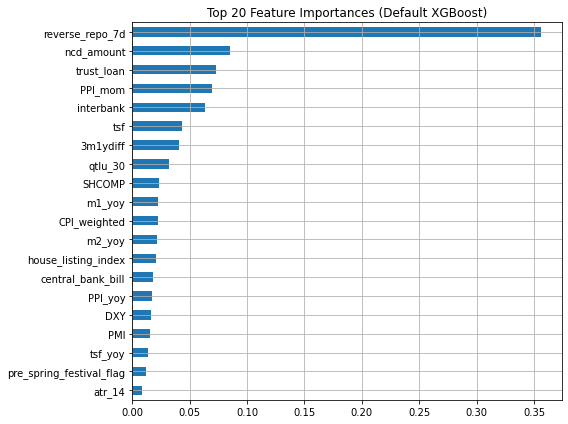

Selected Top 15 features: ['reverse_repo_7d', 'ncd_amount', 'trust_loan', 'PPI_mom', 'interbank', 'tsf', '3m1ydiff', 'qtlu_30', 'SHCOMP', 'm1_yoy', 'CPI_weighted', 'm2_yoy', 'house_listing_index', 'central_bank_bill', 'PPI_yoy']


In [62]:
# 根据因子重要性筛选特征
# 训练默认 XGBoost 模型（不调参）
xgb_default = XGBRegressor(random_state=42)
xgb_default.fit(x_train, y_train)

# 提取特征重要性
importances = pd.Series(xgb_default.feature_importances_, index=x_train.columns)
importances = importances.sort_values(ascending=False)

# 可视化前 20 个重要特征
plt.figure(figsize=(8, 6))
importances.head(20).plot(kind='barh')
plt.title("Top 20 Feature Importances (Default XGBoost)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

# 选择 Top N 特征（你可根据需要调整 N）
top_n = 15
selected_features = importances.head(top_n).index.tolist()
print(f"Selected Top {top_n} features:", selected_features)

# 替换训练/测试集为筛选后的版本
x_train_selected = x_train[selected_features].copy()
x_test_selected = x_test[selected_features].copy()

In [63]:
# 计算类别比例（多数类样本数 / 少数类样本数）
import numpy as np
from collections import Counter

counter = Counter(y_train)
print(counter)

# 举例：若类别 0 有 560 个，类别 1 有 220 个：
# 则 scale_pos_weight = 560 / 220 ≈ 2.55
scale_pos_weight = counter[0] / counter[1]

Counter({0: 1008, 1: 1008})


In [64]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix

# 1. 定义模型
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=Para.seed,
    scale_pos_weight=scale_pos_weight
)

# 2. 参数网格（可按需调整）
param_grid = {
    'n_estimators': [400, 800],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5,0.75],
    'colsample_bytree': [0.4,0.6]
}

# 3. 时间序列交叉验证
tscv = TimeSeriesSplit(n_splits=5)

# 4. 网格搜索
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

# 5. 模型拟合
grid_search_xgb.fit(x_train, y_train)

# 6. 输出最优参数与分数
print("Best parameters:", grid_search_xgb.best_params_)
print("Best CV F1 score:", grid_search_xgb.best_score_)

# 7. 测试集预测与评估
y_pred_xgb = grid_search_xgb.predict(x_test)

print("\n=== XGBoost 测试集性能 ===")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400, 'subsample': 0.75}
Best CV F1 score: 0.633485565933433

=== XGBoost 测试集性能 ===
              precision    recall  f1-score   support

           0       0.71      0.11      0.20       279
           1       0.46      0.94      0.62       226

    accuracy                           0.49       505
   macro avg       0.59      0.53      0.41       505
weighted avg       0.60      0.49      0.39       505

[[ 32 247]
 [ 13 213]]


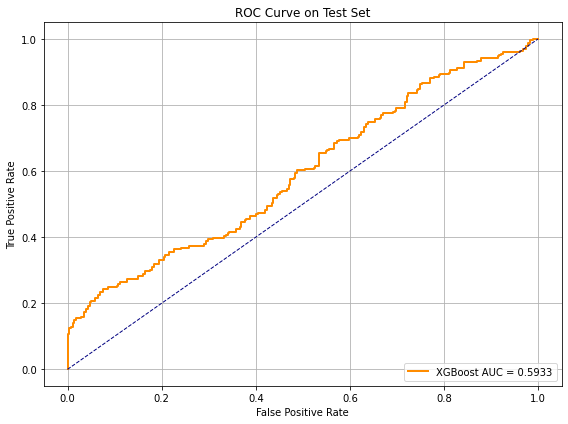

In [65]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 获取预测概率（注意是 predict_proba）
y_score = grid_search_xgb.best_estimator_.predict_proba(x_test)[:, 1]

# 计算 ROC 曲线和 AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# 绘图
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [66]:
# 查看训练集各类数量
print("训练集类别分布：")
print(y_train.value_counts())

# 查看测试集各类数量
print("测试集类别分布：")
print(y_test.value_counts())


训练集类别分布：
ncd_label
0    1008
1    1008
Name: count, dtype: int64
测试集类别分布：
ncd_label
0    279
1    226
Name: count, dtype: int64


In [67]:
x_test_new = x_test.copy()  # 显式创建副本，避免 SettingWithCopyWarning
# 从 best_estimator_ 获取特征重要性（使用 gain）
booster = grid_search_xgb.best_estimator_.get_booster()
importance_dict = booster.get_score(importance_type='gain')
importance_series = pd.Series(importance_dict)
importance_series = importance_series / importance_series.sum()

# 只保留模型中实际使用的特征
valid_cols = [col for col in x_test.columns if col in importance_series.index]

# 构造综合因子
x_test_new["ncd_combined_factor"] = x_test_new[valid_cols].mul(importance_series[valid_cols], axis=1).sum(axis=1)

# 假设 data 是原始完整的 DataFrame，包含所有变量，包括 ncd、date、ncd_next_month 等
x_test_new["ncd"] = data.loc[x_test_new.index, "ncd"].values
x_test_new["date"] = data.loc[x_test_new.index, "date"].values
x_test_new["ncd_next_month"] = data.loc[x_test_new.index, "ncd_next_month"].values

# 查看前几行
print(x_test_new[["ncd_combined_factor"]].head())

      ncd_combined_factor
2016           167.000320
2017           167.000265
2018           165.524420
2019           175.406992
2020           167.238452


In [68]:
# 构造标准化后的 signal
mean = x_test_new["ncd_combined_factor"].mean()
std = x_test_new["ncd_combined_factor"].std()
standardized = (x_test_new["ncd_combined_factor"] - mean) / std

# 转为概率 signal
from scipy.special import expit
x_test_new["ncd_combined_signal"] = expit(2.5 * standardized)

In [69]:
x_test_new.head(50)

,FR007,Shibor,house_listing_index,days_to_month_end,central_bank_bill,m2_yoy,imax_20,PPI_mom,PMI,tsf,...,m1_yoy,DXY,reverse_repo_7d,pre_spring_festival_flag,atr_14,ncd_combined_factor,ncd,date,ncd_next_month,ncd_combined_signal
2016,2.30,2.05,102.191803,25,2.7,10.4,3.0,0.266667,51.083333,1156.43,...,8.0,92.81,2.2,0,0.005714,167.000320,2.95,2020-09-05,3.02,0.916494
2017,2.30,2.05,102.190164,24,2.7,10.4,4.0,0.260000,51.100000,1156.43,...,8.0,92.81,2.2,0,0.005714,167.000265,2.95,2020-09-06,3.02,0.916494
2018,2.25,2.09,102.188525,23,2.7,10.4,5.0,0.253333,51.116667,1156.43,...,8.0,93.07,2.2,0,0.006429,165.524420,2.96,2020-09-07,3.02,0.890409
2019,2.26,2.05,102.186885,22,2.7,10.4,0.0,0.246667,51.133333,1156.43,...,8.0,93.51,2.2,0,0.005714,175.406992,2.97,2020-09-08,3.02,0.983834
2020,2.25,1.61,102.185246,21,2.7,10.4,0.0,0.240000,51.150000,1156.43,...,8.0,93.26,2.2,0,0.007857,167.238452,3.01,2020-09-09,3.00,0.920134
2021,2.20,1.73,102.175410,15,2.7,10.4,5.0,0.200000,51.250000,1156.43,...,8.0,93.08,2.2,0,0.005000,152.139734,3.00,2020-09-15,3.06,0.346996
2022,2.20,1.40,102.173770,14,2.7,10.4,6.0,0.193333,51.266667,1156.43,...,8.0,93.11,2.2,0,0.011429,167.915477,2.91,2020-09-16,3.08,0.929701
2023,2.23,1.77,102.172131,13,2.7,10.4,7.0,0.186667,51.283333,1156.43,...,8.0,92.93,2.2,0,0.012143,166.260600,2.90,2020-09-17,3.08,0.904212
2024,2.32,2.10,102.170492,12,2.7,10.4,8.0,0.180000,51.300000,1156.43,...,8.0,93.00,2.2,0,0.015000,175.887626,2.94,2020-09-18,3.08,0.985320
2025,2.32,2.10,102.168852,11,2.7,10.4,9.0,0.173333,51.316667,1156.43,...,8.0,93.00,2.2,0,0.015000,175.885998,2.94,2020-09-19,3.07,0.985315


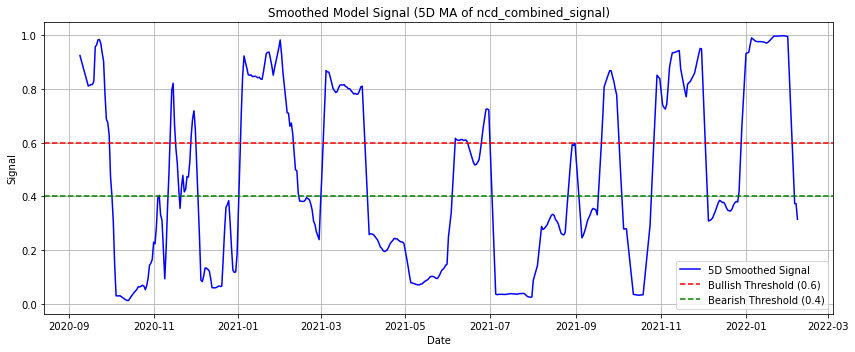

In [70]:
# 计算滑动平均
x_test_new["signal_smooth"] = x_test_new["ncd_combined_signal"].rolling(5).mean()

# 然后绘图
plt.figure(figsize=(12, 5))
plt.plot(x_test_new['date'], x_test_new['signal_smooth'], label='5D Smoothed Signal', color='blue')
plt.axhline(0.6, color='red', linestyle='--', label='Bullish Threshold (0.6)')
plt.axhline(0.4, color='green', linestyle='--', label='Bearish Threshold (0.4)')

plt.title("Smoothed Model Signal (5D MA of ncd_combined_signal)")
plt.xlabel("Date")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [71]:
# 假设你已有列：signal_smooth、ncd、ncd_next_month

def classify_signal(s):
    if s >= 0.6:
        return 1  # 看多
    elif s < 0.4:
        return 0  # 看空
    else:
        return np.nan  # 中性，不出信号

x_test_new["signal_label"] = x_test_new["signal_smooth"].apply(classify_signal)

In [72]:
# 前向填充信号 → 连续识别
x_test_new["regime"] = x_test_new["signal_label"].ffill()
x_test_new["regime_change"] = x_test_new["regime"] != x_test_new["regime"].shift(1)

# 给每段连续区间编号
x_test_new["regime_id"] = x_test_new["regime_change"].cumsum()

# 去掉中性区间（regime为NaN）
signal_df = x_test_new.dropna(subset=["regime"]).copy()

In [73]:
intervals = []

# 遍历每个 regime 区间
for regime_id, group in signal_df.groupby("regime_id"):
    start_date = group["date"].iloc[0]
    end_date = group["date"].iloc[-1]
    regime_type = "看多" if group["regime"].iloc[0] == 1 else "看空"
    n_days = len(group)
    
    # 区间首尾的 ncd 值
    ncd_start = group["ncd"].iloc[0]
    ncd_end = group["ncd"].iloc[-1]
    change_bp = (ncd_end - ncd_start) * 100  # 单位 bp
    max_drawdown = (group["ncd"] - group["ncd"].cummax()).min() * 100  # bp
    
    # 胜负判断（看多 → 收益率下降为正确；看空 → 收益率上升为正确）
    is_correct = (change_bp < 0) if regime_type == "看多" else (change_bp > 0)

    intervals.append({
        "起始日期": start_date,
        "结束日期": end_date,
        "信号类型": regime_type,
        "持续天数": n_days,
        "区间变动(bp)": round(change_bp, 2),
        "最大回撤(bp)": round(max_drawdown, 2),
        "方向是否正确": "正确" if is_correct else "错误"
    })

# 转为表格
interval_df = pd.DataFrame(intervals)

# 显示表格
import pandas as pd
from IPython.display import display
display(interval_df)


,起始日期,结束日期,信号类型,持续天数,区间变动(bp),最大回撤(bp),方向是否正确
0,2020-09-09,2020-10-02,看多,19,1.0,-11.0,错误
1,2020-10-03,2020-11-12,看空,41,15.0,-2.0,正确
2,2020-11-13,2020-11-19,看多,7,10.0,0.0,错误
3,2020-11-20,2020-11-27,看空,8,3.0,-3.0,正确
4,2020-11-28,2020-12-02,看多,5,-12.0,-12.0,正确
5,2020-12-03,2021-01-02,看空,31,-36.0,-39.0,错误
6,2021-01-03,2021-02-13,看多,42,18.0,-11.0,错误
7,2021-02-14,2021-03-02,看空,17,7.0,-3.0,正确
8,2021-03-03,2021-04-03,看多,32,-7.0,-12.0,正确
9,2021-04-04,2021-06-05,看空,60,-19.0,-22.0,错误


In [74]:
# 总区间数
total_intervals = len(interval_df)

# 正确方向数量
num_correct = (interval_df["方向是否正确"] == "正确").sum()

# 胜率
win_rate = num_correct / total_intervals

# 平均区间收益（bp）
avg_return = interval_df["区间变动(bp)"].mean()

# 平均最大回撤（bp）
avg_drawdown = interval_df["最大回撤(bp)"].mean()

# 输出
print(f"📈 总区间数: {total_intervals}")
print(f"✅ 正确方向数: {num_correct}")
print(f"🏆 胜率: {win_rate:.2%}")
print(f"📊 平均区间变动: {avg_return:.2f} bp")
print(f"📉 平均最大回撤: {avg_drawdown:.2f} bp")

📈 总区间数: 18
✅ 正确方向数: 11
🏆 胜率: 61.11%
📊 平均区间变动: -2.94 bp
📉 平均最大回撤: -11.17 bp
